In [1]:
import pickle

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, roc_curve
from sklearn.neighbors import KDTree, NearestNeighbors
import lightgbm as lgbm

In [2]:
data_dir = 'data'

np.random.seed(0)

In [3]:
with open(f'{data_dir}/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    photo_features_list = pickle.load(f)

In [4]:
train_20 = pd.read_csv(f'{data_dir}/proc_train_20.csv')
train_20['z_diff'] = train_20['zoo_x1a35_z_max'] - train_20['Z']
train_20['z_diff_abs'] = np.abs(train_20['z_diff'])
train_20

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs
0,24.196261,-10.109838,-0.011447,20.842147,19.756733,19.267105,19.053641,18.921812,20.784370,19.059832,...,0.756016,0.230554,0.046929,0.077926,-0.039920,0.076411,0.167270,train_20,0.087857,0.087857
1,170.455790,19.878579,-0.009112,21.240596,19.528449,18.831749,18.584223,18.425744,21.187583,18.583677,...,1.004902,0.316399,0.087280,0.072679,-0.037778,3.230971,0.244179,train_20,3.240083,3.240083
2,184.240161,0.634044,-0.007947,19.550209,18.671965,18.413090,18.318118,18.306308,19.526882,18.314960,...,0.304936,0.047188,0.029889,0.037541,-0.058617,0.112295,0.151217,train_20,0.120242,0.120242
3,122.091429,30.926546,-0.005114,22.468104,21.251481,20.282878,20.080934,19.888133,19.921550,19.986937,...,1.306237,0.445164,0.154109,0.027697,0.031030,0.289233,0.102691,train_20,0.294347,0.294347
4,18.832807,25.355562,-0.002058,19.957126,19.084415,18.829452,18.737669,18.721188,19.828226,18.745945,...,0.371765,0.069640,-0.010383,0.020552,-0.026118,2.388000,0.213741,train_20,2.390058,2.390058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576171,36.507807,3.049838,6.541200,24.312627,24.815416,24.377670,23.445890,20.656290,24.437056,21.850588,...,6.195715,6.249677,-4.455494,-5.371558,0.591030,0.923953,0.100922,train_20,-5.617247,5.617247
576172,16.619326,18.475668,6.578712,21.326311,21.173190,20.940946,20.570890,19.888027,20.803366,20.449729,...,1.057533,0.545510,-0.384162,-0.032324,-0.449468,1.999279,0.328354,train_20,-4.579433,4.579433
576173,174.891806,49.894562,6.795398,24.230143,24.980301,23.235294,22.281788,20.942590,20.276665,20.934541,...,3.068268,1.591544,-1.142203,0.614252,-0.436247,0.800600,0.406705,train_20,-5.994798,5.994798
576174,357.461364,6.252772,6.949000,22.151268,21.827504,21.142139,20.551375,20.220181,21.855427,20.521962,...,1.691229,0.705331,-0.320411,-0.020490,-0.187273,2.055263,0.320846,train_20,-4.893737,4.893737


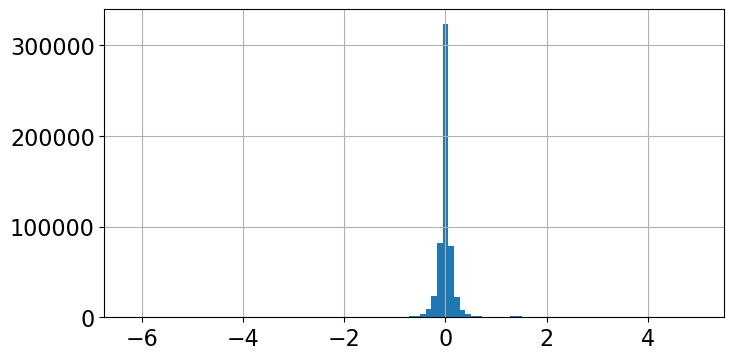

In [5]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(train_20['z_diff'], bins=100);

In [6]:
superset = pd.read_csv(f'{data_dir}/proc_superset.csv')
superset['z_diff'] = superset['zoo_x1a35_z_max'] - superset['Z']
superset['z_diff_abs'] = np.abs(superset['z_diff'])
superset

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs
0,138.718517,56.280226,-1.000000,22.775350,22.611867,22.064465,21.623449,20.869315,19.027926,20.635640,...,1.778069,1.118776,0.312401,-2.771111,-0.349603,0.780652,0.423525,superset,1.780652,1.780652
1,119.299997,22.527369,-0.011447,25.270385,22.467542,21.695831,21.619509,21.896257,25.385881,21.494955,...,0.966636,0.347820,-0.089592,-0.129546,-0.363575,3.359000,0.637353,superset,3.370447,3.370447
2,262.134784,36.734522,-0.011332,24.132008,21.837190,21.616934,21.624107,22.035977,22.642759,21.641023,...,0.361561,0.041704,0.034192,0.138233,-0.130191,3.164000,0.500935,superset,3.175332,3.175332
3,327.439561,-0.195568,-0.011123,23.800413,22.831816,22.300726,22.036541,22.334703,22.015188,22.023386,...,0.674095,0.186281,0.176945,0.110534,-1.779119,3.139719,0.272778,superset,3.150843,3.150843
4,217.129032,15.540025,-0.010959,24.633708,21.997765,21.278476,21.177055,21.145809,24.134848,21.096529,...,0.997279,0.287112,-0.077542,0.006412,0.055268,3.412000,0.350389,superset,3.422959,3.422959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365341,201.934129,12.271040,7.021599,22.945699,21.735764,21.760120,21.570968,21.534457,20.023861,21.483868,...,0.086913,-0.131310,-0.196749,0.066927,-0.193626,2.900859,0.345879,superset,-4.120740,4.120740
365342,36.002095,-0.394057,7.027864,22.591025,22.311335,22.517395,22.057371,21.466233,22.844448,21.938968,...,0.855770,0.771185,-0.259824,0.056779,-0.548422,2.023643,0.290574,superset,-5.004221,5.004221
365343,179.515381,45.946690,7.029899,23.014788,23.557297,22.252898,21.332178,20.479279,20.739668,20.871618,...,2.589669,1.391478,-0.826703,-0.221706,-0.515543,0.735022,0.589784,superset,-6.294876,6.294876
365344,0.306355,6.436817,7.030458,22.151193,22.021175,21.699506,21.433123,21.309049,21.889958,21.365679,...,0.627069,0.249148,0.102827,0.176069,-0.434187,0.373313,0.168273,superset,-6.657146,6.657146


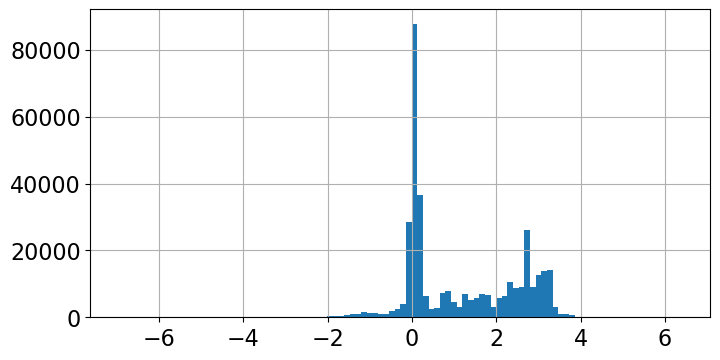

In [7]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(superset['z_diff'], bins=100);

In [8]:
dr16q = pd.read_csv(f'{data_dir}/proc_DR16Q.csv')
dr16q['z_diff'] = dr16q['zoo_x1a35_z_max'] - dr16q['Z']
dr16q['z_diff_abs'] = np.abs(dr16q['z_diff'])
dr16q

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs
0,342.271924,9.512226,-0.000801,23.293404,23.261944,21.289465,20.298392,19.764126,23.072889,19.499491,...,3.337994,1.604808,0.252153,0.084967,-0.177832,0.604661,0.880353,DR16Q_22_v4,0.605462,0.605462
1,204.568544,37.277746,0.000957,21.743158,21.655871,21.408858,21.415014,21.439662,21.521578,21.439872,...,-0.107486,-0.479590,-0.150381,-0.027585,-1.098537,1.290210,0.404038,DR16Q_22_v4,1.289253,1.289253
2,21.348922,16.562467,0.006583,21.433277,21.631844,21.359531,21.324999,20.555731,21.343403,21.354694,...,0.610671,0.327567,-0.222328,-0.233954,-0.598360,0.944000,0.551885,DR16Q_22_v4,0.937417,0.937417
3,191.619513,49.916623,0.008189,20.926910,20.820363,20.758047,20.796802,20.607651,20.917666,20.790658,...,0.135798,0.044767,-0.105558,-0.067531,-0.592861,2.060140,0.699425,DR16Q_22_v4,2.051951,2.051951
4,251.495340,46.344458,0.008549,22.239800,22.200534,21.866438,21.925578,21.336407,22.265156,21.747651,...,1.309582,0.433412,-1.597481,-1.047978,-1.146156,1.349261,0.459766,DR16Q_22_v4,1.340712,1.340712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260365,139.060275,31.044950,7.011245,21.482335,21.251735,20.825714,20.804427,20.632446,21.428634,20.827816,...,0.820260,0.430450,-0.645543,-0.776375,-1.012587,1.015129,0.237470,DR16Q_22_v4,-5.996116,5.996116
260366,341.770887,27.894757,7.011245,21.674032,21.488355,21.111815,20.888735,20.622064,21.690081,20.917052,...,0.544949,0.045182,-0.163817,-0.017016,-0.332926,1.451578,0.759455,DR16Q_22_v4,-5.559667,5.559667
260367,23.595403,16.256553,7.011245,21.688753,21.627957,20.911338,21.081224,20.538696,21.483258,21.040642,...,1.239918,0.589699,-0.528695,-0.567993,-0.993836,1.161900,0.704290,DR16Q_22_v4,-5.849344,5.849344
260368,359.586721,30.006652,7.012407,21.976982,21.611828,21.483509,21.384855,21.397169,21.739690,21.393072,...,0.245344,0.108862,-0.088343,-0.073072,-0.560012,0.916000,0.264474,DR16Q_22_v4,-6.096407,6.096407


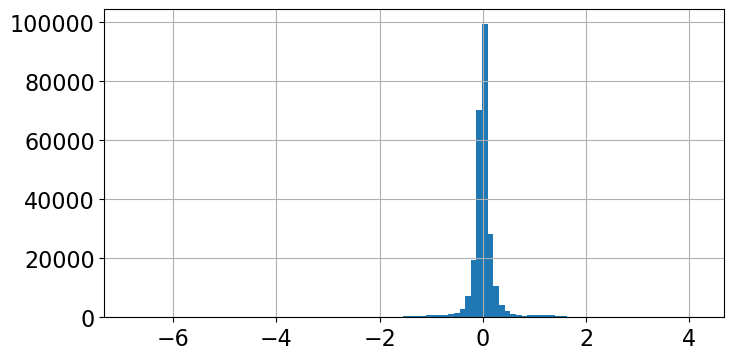

In [9]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(dr16q['z_diff'], bins=100);

In [10]:
prop_dr16q = pd.read_csv(f'{data_dir}/proc_prop_DR16Q.csv')
prop_dr16q['Z_SYS_Z_DIFF'] = prop_dr16q['Z_SYS'] - prop_dr16q['Z']
prop_dr16q['z_diff'] = prop_dr16q['zoo_x1a35_z_max'] - prop_dr16q['Z']
prop_dr16q['z_diff_abs'] = np.abs(prop_dr16q['z_diff'])
prop_dr16q

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,Z_SYS,Z_SYS_ERR,Z_SYS_Z_DIFF,z_diff,z_diff_abs
0,342.271924,9.512226,-0.000801,23.293404,23.261944,21.289465,20.298392,19.764126,23.072889,19.499491,...,0.084967,-0.177832,0.604661,0.880353,DR16Q_22_v4,1.488991,0.005181,1.489792,0.605462,0.605462
1,21.348922,16.562467,0.006583,21.433277,21.631844,21.359531,21.324999,20.555731,21.343403,21.354694,...,-0.233954,-0.598360,0.944000,0.551885,DR16Q_22_v4,1.123435,0.003304,1.116852,0.937417,0.937417
2,191.619513,49.916623,0.008189,20.926910,20.820363,20.758047,20.796802,20.607651,20.917666,20.790658,...,-0.067531,-0.592861,2.060140,0.699425,DR16Q_22_v4,1.560199,0.002642,1.552009,2.051951,2.051951
3,350.520778,30.096626,0.010326,22.146360,21.874411,21.528691,21.549982,21.002606,21.717629,21.443131,...,0.149797,-0.492938,1.017882,0.687900,DR16Q_22_v4,0.990284,0.001618,0.979958,1.007555,1.007555
4,256.791721,45.663833,0.015376,21.763909,22.019808,21.921908,21.779540,22.496530,21.305643,21.725624,...,-1.492849,-1.330181,1.934525,0.162386,DR16Q_22_v4,1.377521,0.002196,1.362145,1.919149,1.919149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,139.060275,31.044950,7.011245,21.482335,21.251735,20.825714,20.804427,20.632446,21.428634,20.827816,...,-0.776375,-1.012587,1.015129,0.237470,DR16Q_22_v4,1.070473,0.001550,-5.940772,-5.996116,5.996116
1358,341.770887,27.894757,7.011245,21.674032,21.488355,21.111815,20.888735,20.622064,21.690081,20.917052,...,-0.017016,-0.332926,1.451578,0.759455,DR16Q_22_v4,1.327632,0.002149,-5.683613,-5.559667,5.559667
1359,23.595403,16.256553,7.011245,21.688753,21.627957,20.911338,21.081224,20.538696,21.483258,21.040642,...,-0.567993,-0.993836,1.161900,0.704290,DR16Q_22_v4,1.153905,0.001124,-5.857340,-5.849344,5.849344
1360,359.586721,30.006652,7.012407,21.976982,21.611828,21.483509,21.384855,21.397169,21.739690,21.393072,...,-0.073072,-0.560012,0.916000,0.264474,DR16Q_22_v4,1.040394,0.000788,-5.972012,-6.096407,6.096407


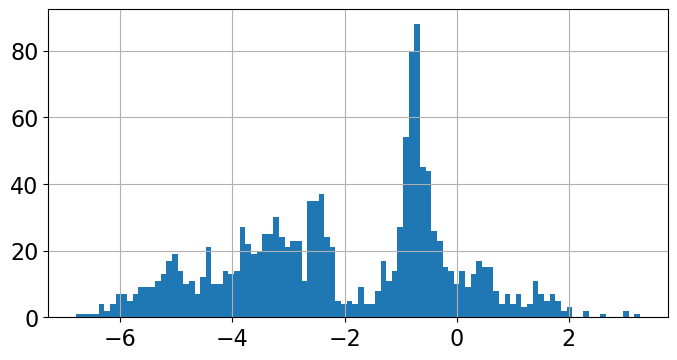

In [11]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(prop_dr16q['z_diff'], bins=100);

In [12]:
train_20_01, train_20_02 = train_20.iloc[range(0, train_20.shape[0], 2)], train_20.iloc[range(0, train_20.shape[0], 2)]

In [21]:
superset_01, superset_02 = superset.iloc[range(0, superset.shape[0], 2)], superset.iloc[range(0, superset.shape[0], 2)]

In [13]:
prop = []
prop_y = []
r = []
for i in np.arange(0.0, 7.0, 0.5):
    t1 = train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t2 = prop_dr16q[(prop_dr16q['Z'] >= i) & (prop_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    min_shape = min(t1.shape[0], t2.shape[0])
    prop.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=min_shape, replace=False)])
    prop_y += [0] * min_shape
    prop.append(t2)
    prop_y += [1] * t2.shape[0]
    r.append((min_shape, min_shape == t2.shape[0]))
prop = pd.concat(prop, axis=0)

tree = KDTree(prop[['RA', 'DEC']].values)
d, idx = tree.query(train_20_02[['RA', 'DEC']])
t = train_20_02.drop(train_20_02.index[d.reshape(-1) < 0.0000001])
s = 0
for e in r:
    if e[1]:
        s += e[0]
diff = sum(prop_y) - (len(prop_y) - sum(prop_y))
prop_02 = []
for k, i in enumerate(np.arange(0.0, 7.0, 0.5)):
    if r[k][1]:
        t1 = t[(t['Z'] >= i) & (t['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
        prop_02.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=round(diff * r[k][0] / s), replace=False)])
prop = pd.concat((prop, pd.concat(prop_02)))
prop_y += [0] * (prop.shape[0] - len(prop_y))

prop['target'] = prop_y
prop.sort_values(by=['Z'], inplace=True)
prop.reset_index(drop=True, inplace=True)
prop

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs,Z_SYS,Z_SYS_ERR,Z_SYS_Z_DIFF,target
0,21.348922,16.562467,0.006583,21.433277,21.631844,21.359531,21.324999,20.555731,21.343403,21.354694,...,-0.598360,0.944000,0.551885,DR16Q_22_v4,0.937417,0.937417,1.123435,0.003304,1.116852,1
1,191.619513,49.916623,0.008189,20.926910,20.820363,20.758047,20.796802,20.607651,20.917666,20.790658,...,-0.592861,2.060140,0.699425,DR16Q_22_v4,2.051951,2.051951,1.560199,0.002642,1.552009,1
2,350.520778,30.096626,0.010326,22.146360,21.874411,21.528691,21.549982,21.002606,21.717629,21.443131,...,-0.492938,1.017882,0.687900,DR16Q_22_v4,1.007555,1.007555,0.990284,0.001618,0.979958,1
3,256.791721,45.663833,0.015376,21.763909,22.019808,21.921908,21.779540,22.496530,21.305643,21.725624,...,-1.330181,1.934525,0.162386,DR16Q_22_v4,1.919149,1.919149,1.377521,0.002196,1.362145,1
4,29.647517,14.428201,0.015529,21.633209,20.683560,22.603633,19.569504,19.464564,21.449550,19.521133,...,-0.179922,1.532090,0.553894,DR16Q_22_v4,1.516561,1.516561,1.384998,0.000606,1.369469,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,214.826084,58.821845,6.968736,23.075584,22.146141,21.740474,21.720555,20.913726,23.073010,21.643220,...,-0.181158,0.411527,0.142483,DR16Q_22_v4,-6.557209,6.557209,1.197120,0.003626,-5.771616,1
2667,321.941715,0.395795,6.970199,24.682609,22.854938,22.091175,22.207972,20.874031,20.041016,22.079386,...,-1.259953,0.628432,0.107931,DR16Q_22_v4,-6.341766,6.341766,1.613146,0.014746,-5.357052,1
2668,218.509881,35.990135,6.977830,23.488554,22.187134,21.572606,20.484018,20.079107,22.135162,20.449075,...,0.088011,1.767968,0.429205,DR16Q_22_v4,-5.209862,5.209862,1.620841,0.003511,-5.356989,1
2669,32.666131,-5.778303,6.999089,22.429732,22.850835,22.206488,21.618127,21.094362,22.549729,20.856127,...,-0.787643,0.827000,0.508095,DR16Q_22_v4,-6.172089,6.172089,0.967996,0.001876,-6.031093,1


In [14]:
prop_balance = []
prop_balance_y = []
for i in np.arange(0.0, 7.0, 0.5):
    t1 = train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t2 = prop_dr16q[(prop_dr16q['Z'] >= i) & (prop_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    min_shape = min(t1.shape[0], t2.shape[0])
    prop_balance.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=min_shape, replace=False)])
    prop_balance_y += [0] * min_shape
    prop_balance.append(t2.iloc[np.random.choice(np.arange(t2.shape[0]), size=min_shape, replace=False)])
    prop_balance_y += [1] * min_shape
prop_balance = pd.concat(prop_balance, axis=0)
prop_balance['target'] = prop_balance_y
prop_balance.sort_values(by=['Z'], inplace=True)
prop_balance.reset_index(drop=True, inplace=True)
prop_balance

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs,Z_SYS,Z_SYS_ERR,Z_SYS_Z_DIFF,target
0,21.348922,16.562467,0.006583,21.433277,21.631844,21.359531,21.324999,20.555731,21.343403,21.354694,...,-0.598360,0.944000,0.551885,DR16Q_22_v4,0.937417,0.937417,1.123435,0.003304,1.116852,1
1,191.619513,49.916623,0.008189,20.926910,20.820363,20.758047,20.796802,20.607651,20.917666,20.790658,...,-0.592861,2.060140,0.699425,DR16Q_22_v4,2.051951,2.051951,1.560199,0.002642,1.552009,1
2,350.520778,30.096626,0.010326,22.146360,21.874411,21.528691,21.549982,21.002606,21.717629,21.443131,...,-0.492938,1.017882,0.687900,DR16Q_22_v4,1.007555,1.007555,0.990284,0.001618,0.979958,1
3,180.442634,29.382789,0.011077,21.286000,20.499428,20.386539,20.677471,20.193778,17.879187,16.788369,...,0.104597,0.041410,0.245413,train_20,0.030333,0.030333,NaN,NaN,NaN,0
4,256.791721,45.663833,0.015376,21.763909,22.019808,21.921908,21.779540,22.496530,21.305643,21.725624,...,-1.330181,1.934525,0.162386,DR16Q_22_v4,1.919149,1.919149,1.377521,0.002196,1.362145,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219,33.477888,1.783505,6.491304,21.375048,21.066654,20.939947,20.827684,20.616122,21.434222,20.781346,...,0.306503,2.155601,0.689190,DR16Q_22_v4,-4.335703,4.335703,1.816241,0.006012,-4.675062,1
2220,203.510898,36.462455,6.539738,22.230666,21.192220,21.080189,21.031378,21.166196,22.270752,21.041170,...,-0.820226,2.962000,0.849734,DR16Q_22_v4,-3.577738,3.577738,0.777471,0.001737,-5.762267,1
2221,16.619326,18.475668,6.578712,21.326311,21.173190,20.940946,20.570890,19.888027,20.803366,20.449729,...,-0.449468,1.999279,0.328354,train_20,-4.579433,4.579433,NaN,NaN,NaN,0
2222,16.327773,31.734917,6.940807,22.219946,22.012164,21.424983,20.795165,20.312607,22.019689,20.628549,...,-0.208802,1.839000,0.433325,DR16Q_22_v4,-5.101807,5.101807,1.587551,0.000591,-5.353257,1


In [15]:
t = Table.read(f'{data_dir}/23_DR16Q_v4.fits')
dr16q_full = t[['THING_ID', 'RA', 'DEC', 'Z']].to_pandas()
dr16q_full.drop_duplicates(subset=['THING_ID'], inplace=True, keep='last')
dr16q_full.sort_values(by=['Z'], inplace=True)
dr16q_full.reset_index(inplace=True, drop=True)
dr16q_full

,THING_ID,RA,DEC,Z
0,516761386,201.119434,57.278030,-999.000000
1,212210600,164.698568,11.187737,-999.000000
2,231361019,120.312580,13.611725,-999.000000
3,340427857,249.214456,26.449127,-999.000000
4,452196647,125.561805,43.283863,-0.002643
...,...,...,...,...
749325,256231263,23.595403,16.256553,7.011245
749326,369399125,359.586721,30.006652,7.012407
749327,285082507,134.966785,19.867148,7.014935
749328,441752498,123.520783,41.513521,7.014980


In [16]:
def angular_dist(x, y):
    ra_01, dec_01 = x[0], x[1]
    ra_02, dec_02 = y[0], y[1]
    ra_01 = ra_01 * np.pi / 180
    ra_02 = ra_02 * np.pi / 180
    dec_01 = dec_01 * np.pi / 180
    dec_02 = dec_02 * np.pi / 180
    return np.arccos(np.minimum(
        np.sin(dec_01) * np.sin(dec_02) +
        np.cos(dec_01) * np.cos(dec_02) * np.cos(ra_01 - ra_02),
        1
    )) * 180 / (np.pi)

kd_tree = KDTree(dr16q_full[['RA', 'DEC']].values)
d, idx = kd_tree.query(train_20[['RA', 'DEC']].values, k=10)

a = []
b = []
t1 = train_20[['RA', 'DEC']].values
t2 = dr16q_full[['RA', 'DEC']].values
for i in tqdm(range(idx.shape[0])):
    min_dist = 10000
    min_id = None
    for id_ in idx[i]:
        dist = angular_dist(t1[i], t2[id_])
        if dist < min_dist:
            min_dist = dist
            min_id = id_
    if min_dist < 1/3600:
        a.append(i)
        b.append(min_id)

100%|██████████| 576176/576176 [01:00<00:00, 9567.71it/s]


In [17]:
dr16q_union = pd.concat((
    dr16q, 
    train_20.iloc[np.unique(np.array(a))]
))

prop_dens = []
prop_dens_y = []
for i in np.arange(0.0, 7.0, 0.5):
    t0 = dr16q_union[(dr16q_union['Z'] >= i) & (dr16q_union['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t1 = train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t2 = prop_dr16q[(prop_dr16q['Z'] >= i) & (prop_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    prop_dens.append(t2)
    prop_dens_y += [1] * t2.shape[0]
    prop_dens.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=t0.shape[0]-t2.shape[0], replace=True)])
    prop_dens_y += [0] * (t0.shape[0]-t2.shape[0])
prop_dens = pd.concat(prop_dens, axis=0)
prop_dens['target'] = prop_dens_y
prop_dens.sort_values(by=['Z'], inplace=True)
prop_dens.reset_index(drop=True, inplace=True)
prop_dens

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,Z_SYS,Z_SYS_ERR,Z_SYS_Z_DIFF,z_diff,z_diff_abs,target
0,60.008919,-5.366267,0.000061,21.900875,20.742203,20.202941,20.019572,19.923326,21.561752,19.950216,...,0.090733,0.194536,0.194590,train_20,NaN,NaN,NaN,0.194475,0.194475,0
1,330.373757,27.460380,0.000104,22.124104,21.459829,21.400353,21.560758,21.178317,22.053991,21.579035,...,-0.131584,2.818173,0.685229,train_20,NaN,NaN,NaN,2.818069,2.818069,0
2,199.269471,37.953998,0.001186,21.358585,20.946885,20.893367,21.051361,20.935680,21.407880,20.918672,...,-1.074080,0.051911,0.179325,train_20,NaN,NaN,NaN,0.050725,0.050725,0
3,25.572359,26.365745,0.001257,20.831857,20.555653,20.766712,21.302531,20.807997,20.817443,21.187935,...,-0.566368,0.037174,0.293759,train_20,NaN,NaN,NaN,0.035916,0.035916,0
4,158.067875,27.663529,0.001768,20.824550,20.566441,20.747891,21.762156,21.589110,20.667194,21.208040,...,-1.084583,0.020401,0.365772,train_20,NaN,NaN,NaN,0.018633,0.018633,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696738,214.826084,58.821845,6.968736,23.075584,22.146141,21.740474,21.720555,20.913726,23.073010,21.643220,...,-0.181158,0.411527,0.142483,DR16Q_22_v4,1.197120,0.003626,-5.771616,-6.557209,6.557209,1
696739,321.941715,0.395795,6.970199,24.682609,22.854938,22.091175,22.207972,20.874031,20.041016,22.079386,...,-1.259953,0.628432,0.107931,DR16Q_22_v4,1.613146,0.014746,-5.357052,-6.341766,6.341766,1
696740,218.509881,35.990135,6.977830,23.488554,22.187134,21.572606,20.484018,20.079107,22.135162,20.449075,...,0.088011,1.767968,0.429205,DR16Q_22_v4,1.620841,0.003511,-5.356989,-5.209862,5.209862,1
696741,32.666131,-5.778303,6.999089,22.429732,22.850835,22.206488,21.618127,21.094362,22.549729,20.856127,...,-0.787643,0.827000,0.508095,DR16Q_22_v4,0.967996,0.001876,-6.031093,-6.172089,6.172089,1


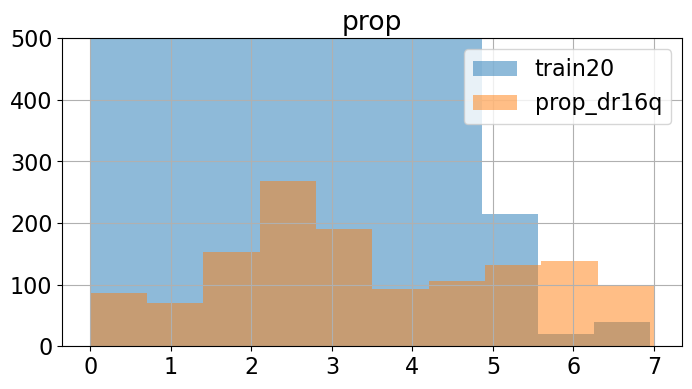

In [18]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.ylim(0, 500)
plt.grid()

plt.hist(prop_dens[prop_dens['target'] == 0]['Z'], alpha=0.5, label='train20')
plt.hist(prop_dens[prop_dens['target'] == 1]['Z'], alpha=0.5, label='prop_dr16q')
plt.legend()
plt.title('prop');

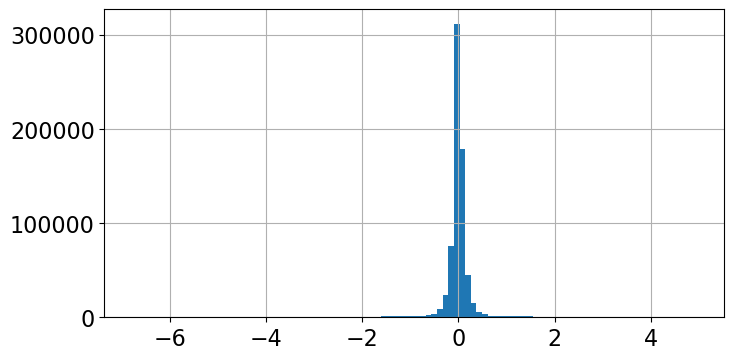

In [19]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(prop_dens['z_diff'], bins=100);

In [22]:
print(f'Test (train20) shape: {train_20_02.shape[0]}')
print(f'Test (superset) shape: {superset_02.shape[0]}')
print(f'DR16Q shape: {dr16q.shape[0]}')
print(f'prop_DR16Q shape: {prop_dr16q.shape[0]}')
print(f'prop_dens (prop_DR16Q) shape: {prop_dens[prop_dens["target"] == 1].shape[0]}')
print(f'prop_dens (train20) shape: {prop_dens[prop_dens["target"] == 0].shape[0]}')

Test (train20) shape: 288088
Test (superset) shape: 182673
DR16Q shape: 260370
prop_DR16Q shape: 1362
prop_dens (prop_DR16Q) shape: 1336
prop_dens (train20) shape: 695407


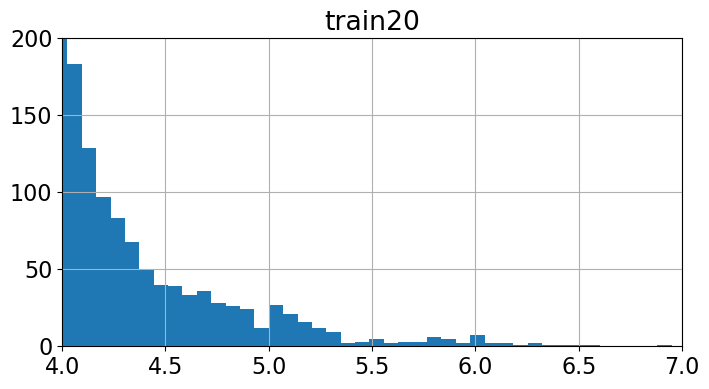

In [23]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.xlim(4, 7)
plt.ylim(0, 200)
plt.grid()

plt.hist(train_20_02['Z'], bins=100)
plt.title('train20');

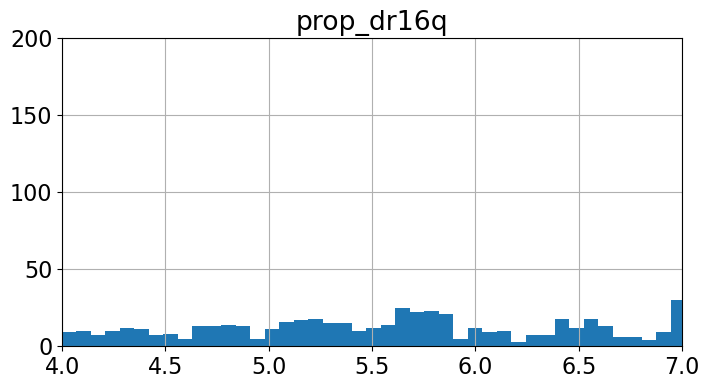

In [24]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.xlim(4, 7)
plt.ylim(0, 200)
plt.grid()

plt.hist(prop_dr16q['Z'], bins=100)
plt.title('prop_dr16q');

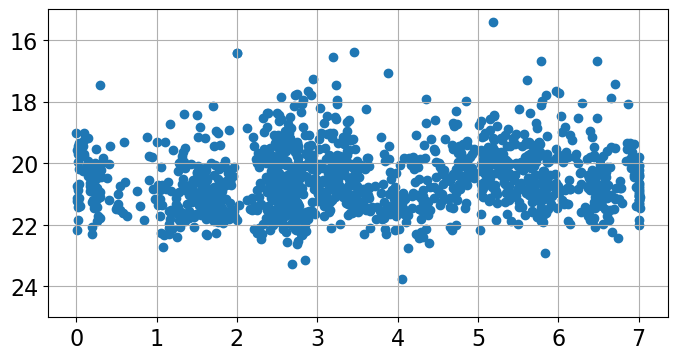

In [25]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.ylim(25, 15)
plt.grid()

plt.scatter(prop_dr16q['Z'], prop_dr16q['decals8tr_z']);

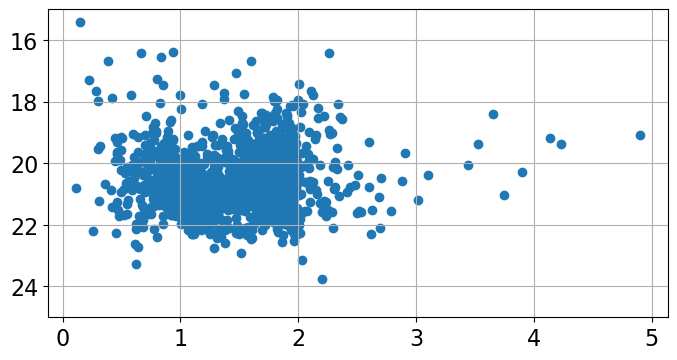

In [26]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.ylim(25, 15)
plt.grid()

plt.scatter(prop_dr16q['Z_SYS'], prop_dr16q['decals8tr_z']);

In [27]:
# train_20_01, train_20_02 = train_20.iloc[range(0, train_20.shape[0], 2)], train_20.iloc[range(0, train_20.shape[0], 2)]

In [28]:
# superset_01, superset_02 = superset.iloc[range(0, superset.shape[0], 2)], superset.iloc[range(0, superset.shape[0], 2)]

In [29]:
features_list = ['zoo_x1a35_z_maxConf', 'z_diff_abs'] + photo_features_list

In [30]:
X_01 = np.concatenate([train_20_01[features_list].values, superset_01[features_list].values], axis=0)
y_01 = np.array([0] * train_20_01.shape[0] + [1] * superset_01.shape[0])
X_02 = np.concatenate([train_20_02[features_list].values, superset_02[features_list].values], axis=0)
y_02 = np.array([0] * train_20_02.shape[0] + [1] * superset_02.shape[0])

test = pd.concat((train_20_02, superset_02))
test['target'] = y_02

In [31]:
def recall_50(y_true, y_pred):
    return 'recall_50', recall_score(y_true, y_pred > 0.5), True

def precision_50(y_true, y_pred):
    if np.sum(y_true == 0) == 0:
        return 'precision_50', 0, True
    return 'precision_50', precision_score(y_true, y_pred > 0.5), True

def recall_70(y_true, y_pred):
    return 'recall_70', recall_score(y_true, y_pred > 0.7), True

def precision_70(y_true, y_pred):
    if np.sum(y_true == 0) == 0:
        return 'precision_70', 0, True
    return 'precision_70', precision_score(y_true, y_pred > 0.7), True

def recall_90(y_true, y_pred):
    return 'recall_90', recall_score(y_true, y_pred > 0.9), True

def precision_90(y_true, y_pred):
    if np.sum(y_true == 0) == 0:
        return 'precision_90', 0, True
    return 'precision_90', precision_score(y_true, y_pred > 0.9), True

In [81]:
import warnings
warnings.filterwarnings('ignore')

boost = lgbm.LGBMClassifier(
    n_estimators=1000, max_depth=6,
    n_jobs=8
)
boost.fit(
    X_01, y_01, 
    eval_set=[
        (X_02, y_02), 
        (prop_dr16q[features_list].values, np.array([1]*prop_dr16q.shape[0])), 
        (dr16q[features_list].values, np.array([1]*dr16q.shape[0]))
    ], 
    eval_metric=[
        recall_50, precision_50, 
        recall_70, precision_70, 
        recall_90, precision_90,
    ], 
    verbose=50
)

[50]	valid_0's binary_logloss: 0.139773	valid_0's recall_50: 0.929716	valid_0's precision_50: 0.936974	valid_0's recall_70: 0.885413	valid_0's precision_70: 0.960463	valid_0's recall_90: 0.721869	valid_0's precision_90: 0.988871	valid_1's binary_logloss: 0.954747	valid_1's recall_50: 0.60279	valid_1's precision_50: 0	valid_1's recall_70: 0.496329	valid_1's precision_70: 0	valid_1's recall_90: 0.223935	valid_1's precision_90: 0	valid_2's binary_logloss: 3.93869	valid_2's recall_50: 0.0441948	valid_2's precision_50: 0	valid_2's recall_70: 0.0205822	valid_2's precision_70: 0	valid_2's recall_90: 0.00392902	valid_2's precision_90: 0
[100]	valid_0's binary_logloss: 0.124217	valid_0's recall_50: 0.938475	valid_0's precision_50: 0.942074	valid_0's recall_70: 0.900264	valid_0's precision_70: 0.964172	valid_0's recall_90: 0.76355	valid_0's precision_90: 0.988911	valid_1's binary_logloss: 1.03077	valid_1's recall_50: 0.585903	valid_1's precision_50: 0	valid_1's recall_70: 0.493392	valid_1's prec

LGBMClassifier(max_depth=6, n_estimators=1000, n_jobs=8)

<BarContainer object of 67 artists>

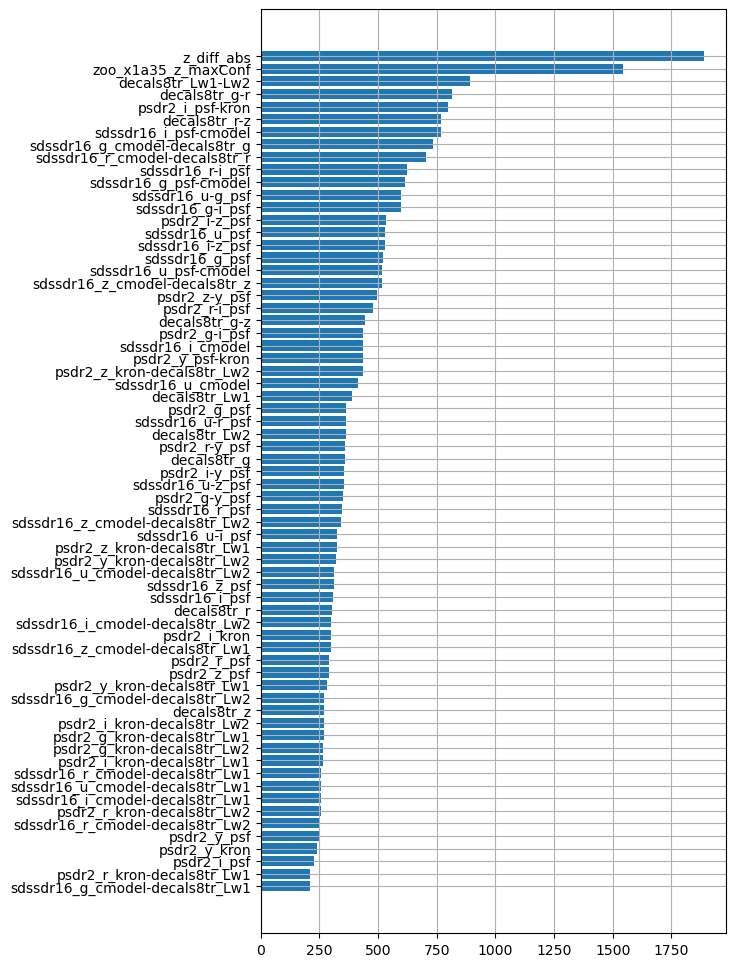

In [82]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(6, 12))
plt.grid()

plt.barh(np.array(features_list)[boost.feature_importances_.argsort()[::]], sorted(boost.feature_importances_)[::])

In [83]:
preds = boost.predict_proba(X_02)[:, 1]
test['preds'] = preds
zm3 = np.concatenate(((train_20_02['Z'] > 3).values, (superset_02['Z'] > 3).values))
print(zm3.mean())
zm4 = np.concatenate(((train_20_02['Z'] > 4).values, (superset_02['Z'] > 4).values))
print(zm4.mean())

0.03968255654142973
0.005183097155456803


In [84]:
prop_dr16q_preds = boost.predict_proba(prop_dr16q[features_list])[:, 1]
prop_dr16q_zm3 = prop_dr16q['Z'] > 3
print(prop_dr16q_zm3.mean())
prop_dr16q_zm4 = prop_dr16q['Z'] > 4
print(prop_dr16q_zm4.mean())

0.5367107195301027
0.3854625550660793


In [85]:
prop_preds = boost.predict_proba(prop[features_list])[:, 1]
prop['preds'] = prop_preds
prop_zm3 = prop['Z'] > 3
print(prop_zm3.mean())
prop_zm4 = prop['Z'] > 4
print(prop_zm4.mean())

0.4739797828528641
0.30213403219767876


In [86]:
prop_balance_preds = boost.predict_proba(prop_balance[features_list])[:, 1]
prop_balance['preds'] = prop_balance_preds
prop_balance_zm3 = prop_balance['Z'] > 3
print(prop_balance_zm3.mean())
prop_balance_zm4 = prop_balance['Z'] > 4
print(prop_balance_zm4.mean())

0.43300359712230213
0.24820143884892087


In [87]:
prop_dens_preds = boost.predict_proba(prop_dens[features_list])[:, 1]
prop_dens['preds'] = prop_dens_preds
prop_dens_zm3 = prop_dens['Z'] > 3
print(prop_dens_zm3.mean())
prop_dens_zm4 = prop_dens['Z'] > 4
print(prop_dens_zm4.mean())

0.054804999834946314
0.004058885413990524


In [88]:
dr16q_preds = boost.predict_proba(dr16q[features_list])[:, 1]
dr16q['preds'] = dr16q_preds
dr16q_zm3 = dr16q['Z'] > 3
print(dr16q_zm3.mean())
dr16q_zm4 = dr16q['Z'] > 4
print(dr16q_zm4.mean())

0.023036448131505165
0.0038253254983293006


In [89]:
precision, recall, thresholds = precision_recall_curve(y_02, preds)

In [90]:
precision_z3, recall_z3, thresholds_z3 = precision_recall_curve(y_02[zm3], preds[zm3])
precision_z4, recall_z4, thresholds_z4 = precision_recall_curve(y_02[zm4], preds[zm4])

In [91]:
prop_dr16q_recall = np.concatenate((
    (prop_dr16q_preds > thresholds.reshape(-1, 1)).sum(1) / prop_dr16q_preds.shape[0],
    np.array([0])
))

In [92]:
prop_dr16q_recall_z3 = np.concatenate((
    (prop_dr16q_preds[prop_dr16q_zm3] > thresholds_z3.reshape(-1, 1)).sum(1) / prop_dr16q_preds[prop_dr16q_zm3].shape[0],
    np.array([0])
))
prop_dr16q_recall_z4 = np.concatenate((
    (prop_dr16q_preds[prop_dr16q_zm4] > thresholds_z4.reshape(-1, 1)).sum(1) / prop_dr16q_preds[prop_dr16q_zm4].shape[0],
    np.array([0])
))

In [93]:
prop_precision, prop_recall, prop_thresholds = precision_recall_curve(prop['target'], prop_preds)

In [94]:
prop_precision_z3, prop_recall_z3, prop_thresholds_z3 = precision_recall_curve(prop[prop_zm3]['target'], prop_preds[prop_zm3])
prop_precision_z4, prop_recall_z4, prop_thresholds_z4 = precision_recall_curve(prop[prop_zm4]['target'], prop_preds[prop_zm4])

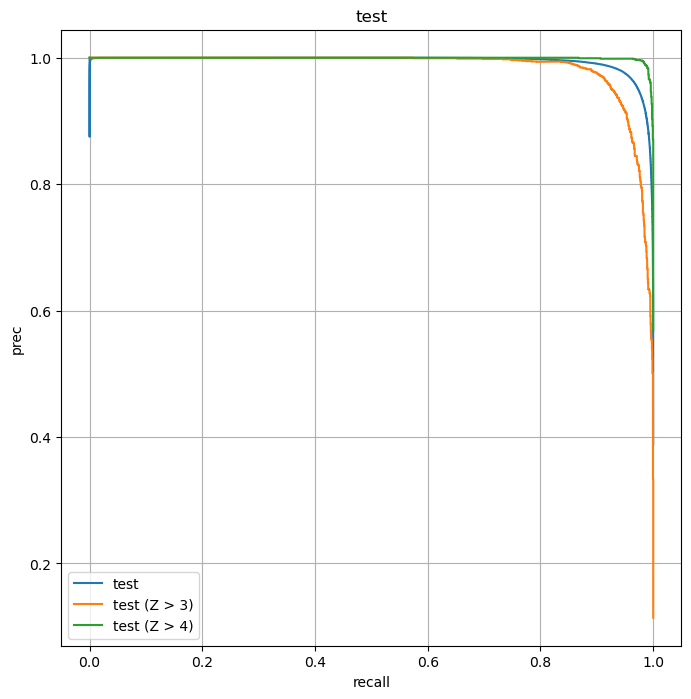

In [95]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 8))
plt.grid()

plt.plot(recall, precision, label='test')
# plt.plot(prop_dr16q_recall, precision, label='prop_dr16q')
plt.plot(recall_z3, precision_z3, label=f'test (Z > {3})')
# plt.plot(prop_dr16q_recall_z3, precision_z3, label=f'prop_dr16q (Z > {3})')
plt.plot(recall_z4, precision_z4, label=f'test (Z > {4})')
# plt.plot(prop_dr16q_recall_z4, precision_z4, label=f'prop_dr16q (Z > {4})')
plt.xlabel('recall')
plt.ylabel('prec')
plt.legend()
plt.title('test');

In [96]:
def count_all(data, thr):
    tp = ((data['preds'] >= thr) * (data['target'] == 1)).sum()
    fp = ((data['preds'] >= thr) * (data['target'] == 0)).sum()
    tn = ((data['preds'] < thr) * (data['target'] == 0)).sum()
    fn = ((data['preds'] < thr) * (data['target'] == 1)).sum()
    
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return prec, recall, fpr

def plot_all(data, quants, thrs, data_name, cumul=False):
    precs = []
    recalls = []
    fpr_1 = []
    sample_num = []
    for i in range(len(quants)-1):
        if cumul:
            t = data[data['Z'] >= quants[i]]
        else:
            t = data[(data['Z'] >= quants[i]) & (data['Z'] <= quants[i+1])]
        prec, recall, fpr = count_all(t, thrs[i])
        precs.append(prec)
        recalls.append(recall)
        fpr_1.append(1-fpr)
        sample_num.append((t[t['target'] == 0].shape[0], t[t['target'] == 1].shape[0]))
        
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(20, 8))
    plt.xlim(quants[0]-0.01, quants[-1]+0.01)
    plt.ylim(0, 1.02)
    plt.xticks(np.arange(int(quants[0]), 7.5, 0.5), rotation=45)
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    plt.grid()
    
    plt.plot((quants[1:] + quants[:-1]) / 2, precs, label=f'prec', marker='o')
    plt.plot((quants[1:] + quants[:-1]) / 2, recalls, label=f'recall', marker='o')
    plt.plot((quants[1:] + quants[:-1]) / 2, fpr_1, label=f'1-fpr', marker='o')
    plt.plot((quants[1:] + quants[:-1]) / 2, thrs, label=f'thresholds', marker='o')
    plt.vlines(quants, ymin=-0.5, ymax=1.5, colors='black')
    for i, x in enumerate(((quants[1:] + quants[:-1]) / 2) - 0.05):
        plt.text(x, 0.52, f'{sample_num[i][0]}', size=7, c='b')
        plt.text(x, 0.48, f'{sample_num[i][1]}', size=7, c='r')
    plt.legend()
    plt.xlabel('Redshift')
    plt.ylabel('prec|recall|1-fpr')
    plt.title(f'{data_name}');
    
    return precs, recalls, fpr_1

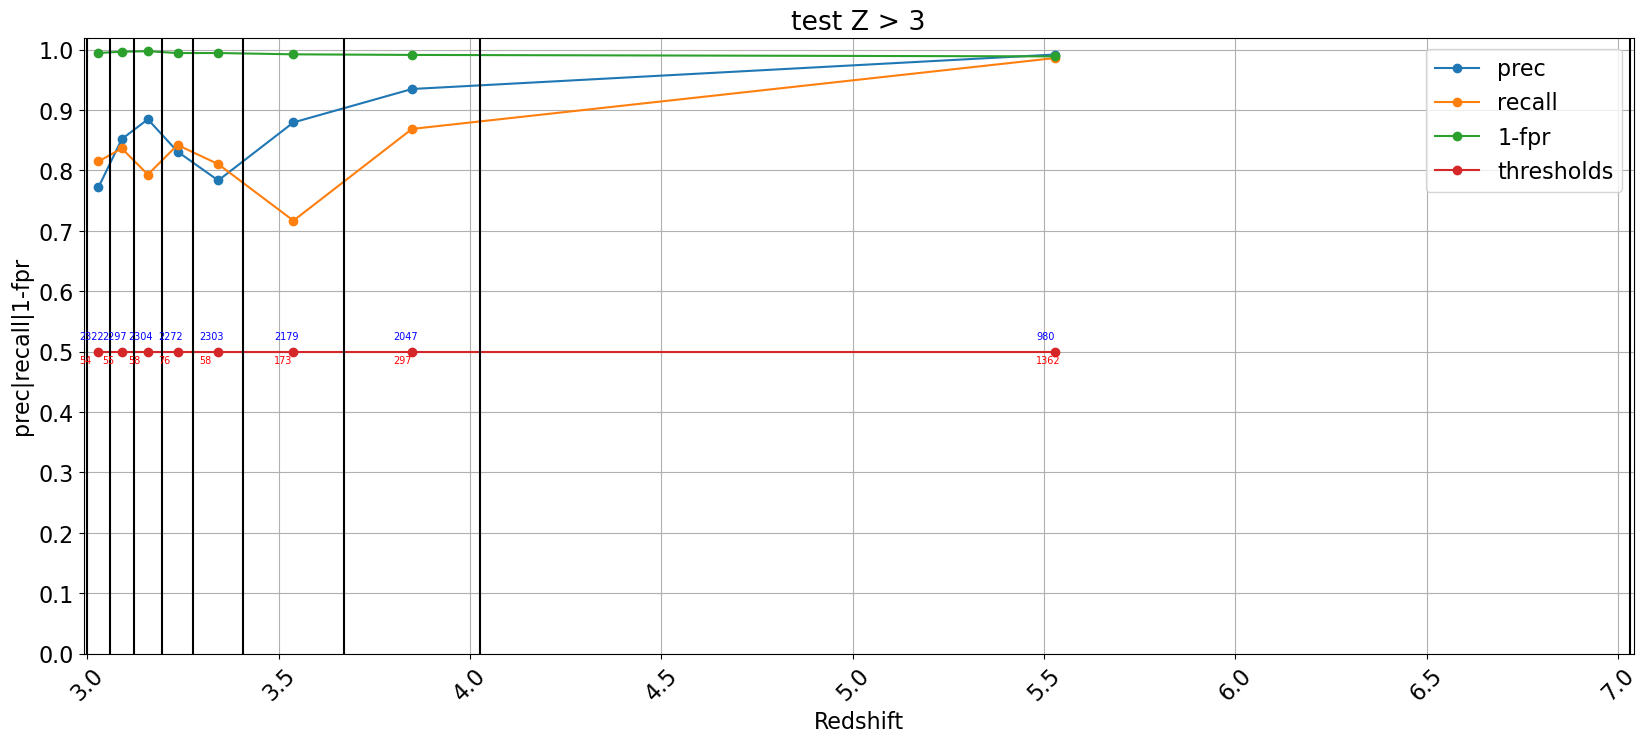

In [97]:
test_z = test[test['Z'] >= 3]
quants_test_z = np.quantile(test_z['Z'], np.arange(0.0, 1.125, 0.125))
thrs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
                     
precs, _, _ = plot_all(test_z, quants_test_z, thrs, 'test Z > 3')

In [98]:
prec, recall, fpr = count_all(test_z, 0.5)
print(prec)
print(recall)
print(1 - fpr)

0.9521970062771608
0.9245194561650257
0.9940357852882704


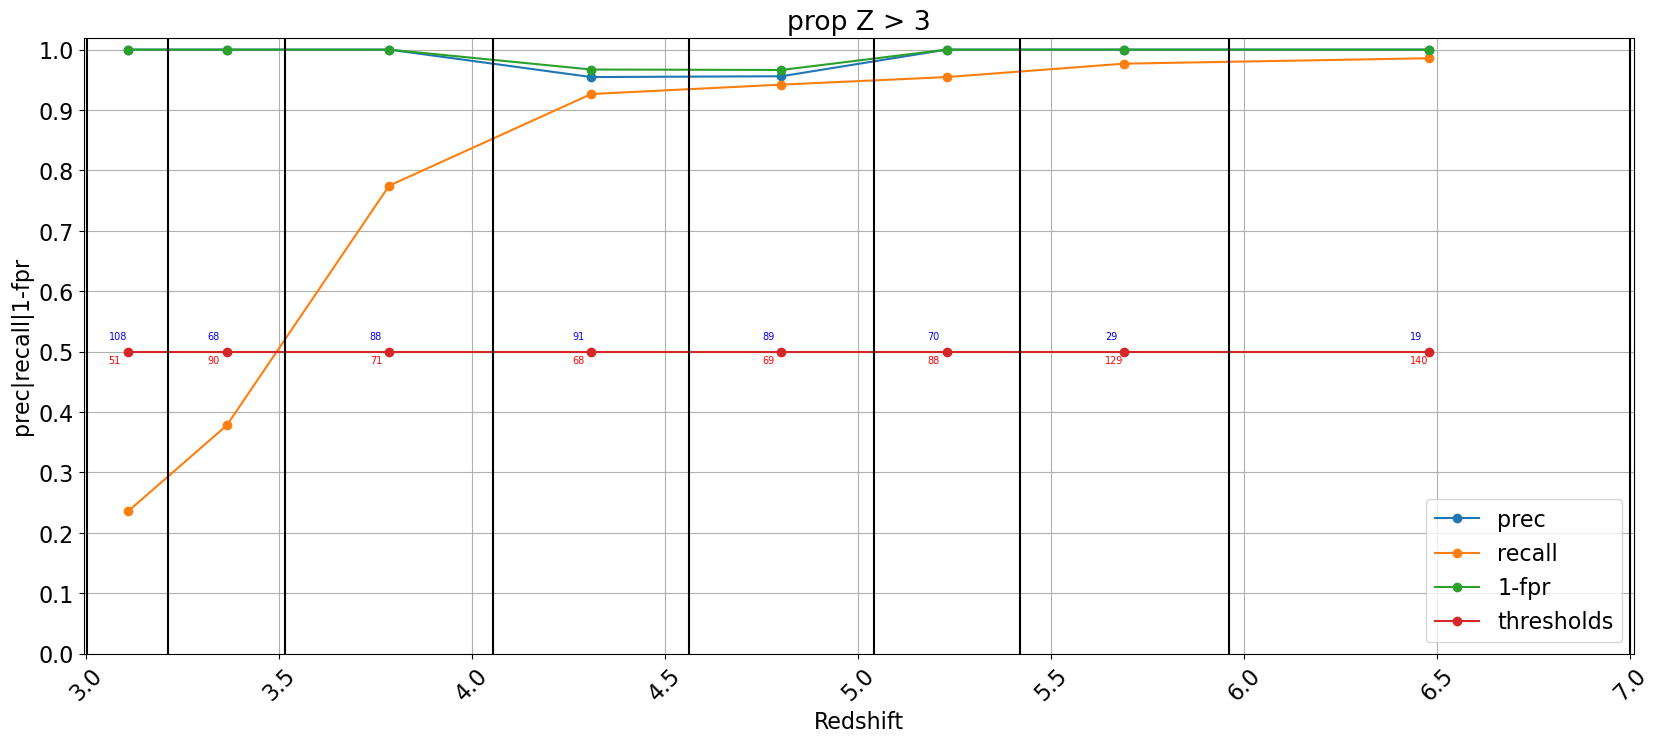

In [99]:
prop_z = prop[prop['Z'] >= 3]
quants_prop_z = np.quantile(prop_z['Z'], np.arange(0.0, 1.125, 0.125))
thrs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

_, _, _ = plot_all(prop_z, quants_prop_z, thrs, 'prop Z > 3')

In [100]:
prec, recall, fpr = count_all(prop_z, 0.5)
print(prec)
print(recall)
print(1 - fpr)

0.9897084048027445
0.8172804532577904
0.9892857142857143


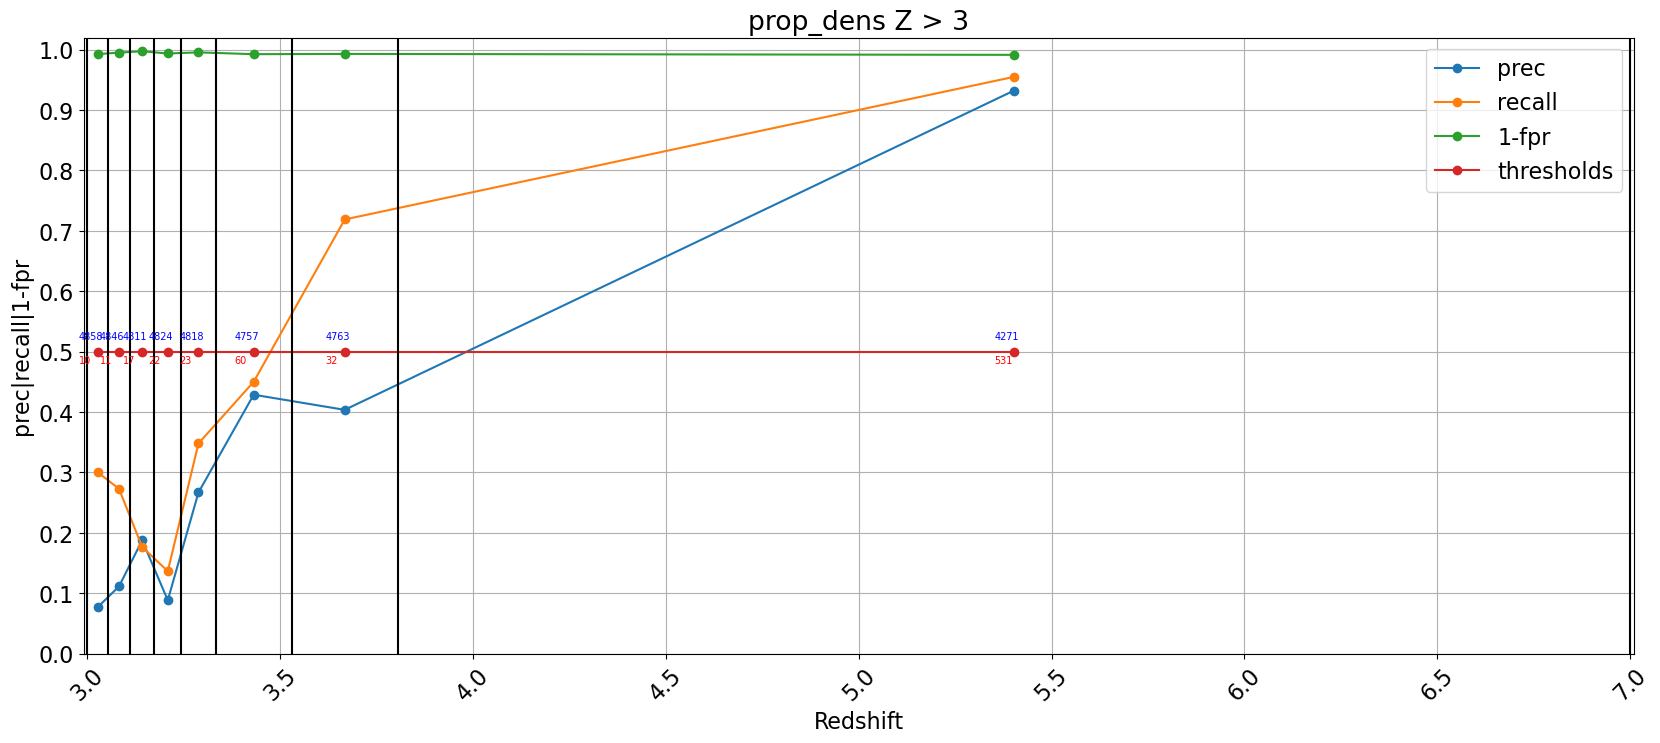

In [101]:
prop_dens_z = prop_dens[prop_dens['Z'] >= 3]
quants_prop_dens_z = np.quantile(prop_dens_z['Z'], np.arange(0.0, 1.125, 0.125))
thrs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

_, _, _ = plot_all(prop_dens_z, quants_prop_dens_z, thrs, 'prop_dens Z > 3')

In [102]:
prec, recall, fpr = count_all(prop_dens_z, 0.5)
print(prec)
print(recall)
print(1 - fpr)

0.7158808933002482
0.8172804532577904
0.9939058466615217


In [103]:
ge = pd.read_csv(f'{data_dir}/dr16q_outliers_georgeedit.csv')
ge = ge[~ge['Gtest_zooTrue'].isna()]
manual_prec = []
for i in range(len(quants_prop_z)-1):
    t = ge[(ge['Z_DR16Q'] >= quants_prop_z[i]) & (ge['Z_DR16Q'] <= quants_prop_z[i+1])]
    manual_prec.append(t['Gtest_zooTrue'].sum() / t.shape[0])

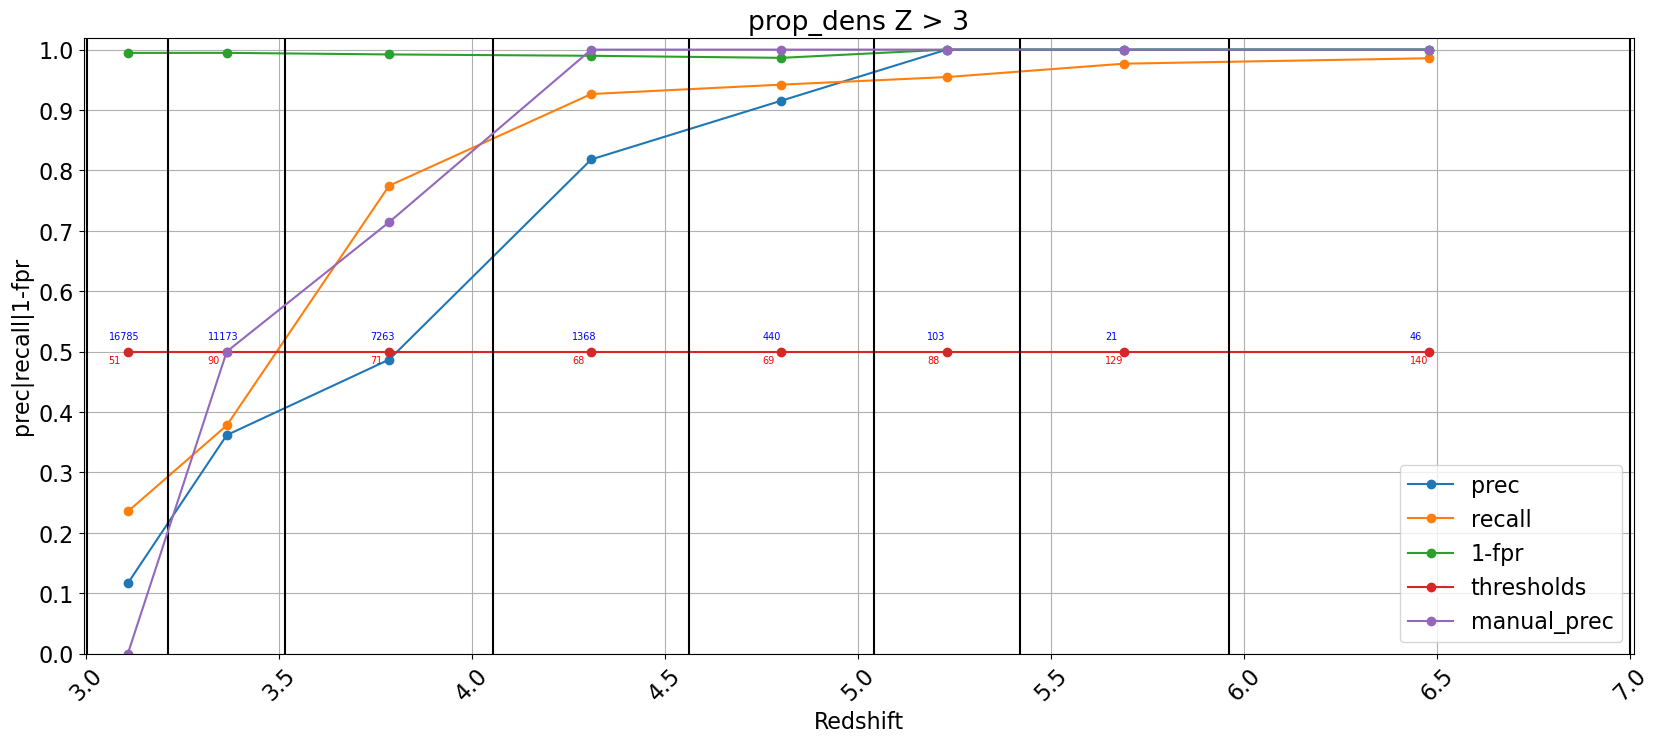

In [104]:
thrs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

_, _, _ = plot_all(prop_dens_z, quants_prop_z, thrs, 'prop_dens Z > 3')
plt.plot((quants_prop_z[1:] + quants_prop_z[:-1]) / 2, manual_prec, label=f'manual_prec', marker='o')
plt.legend()

In [105]:
ge = pd.read_csv(f'{data_dir}/dr16q_outliers_georgeedit.csv')
ge = ge[~ge['Gtest_zooTrue'].isna()]
manual_prec = []
for i in quants_prop_z[:-1]:
    t = ge[ge['Z_DR16Q'] >= i]
    manual_prec.append(t['Gtest_zooTrue'].sum() / t.shape[0])

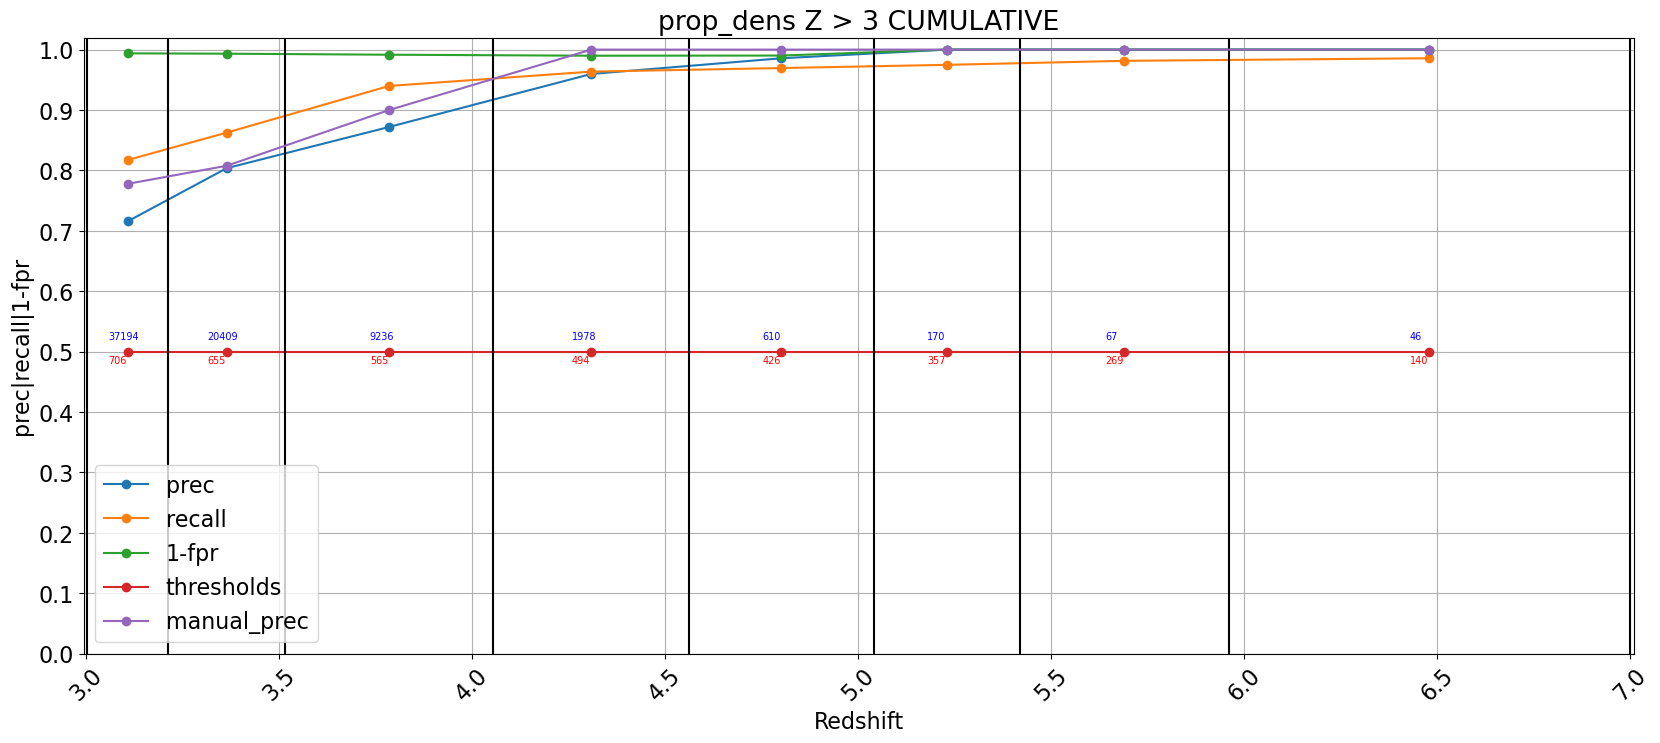

In [106]:
thrs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

_, _, _ = plot_all(prop_dens_z, quants_prop_z, thrs, 'prop_dens Z > 3 CUMULATIVE', cumul=True)
plt.plot((quants_prop_z[1:] + quants_prop_z[:-1]) / 2, manual_prec, label=f'manual_prec', marker='o')
plt.legend()

Text(0.5, 1.0, 'prop_DR16Q')

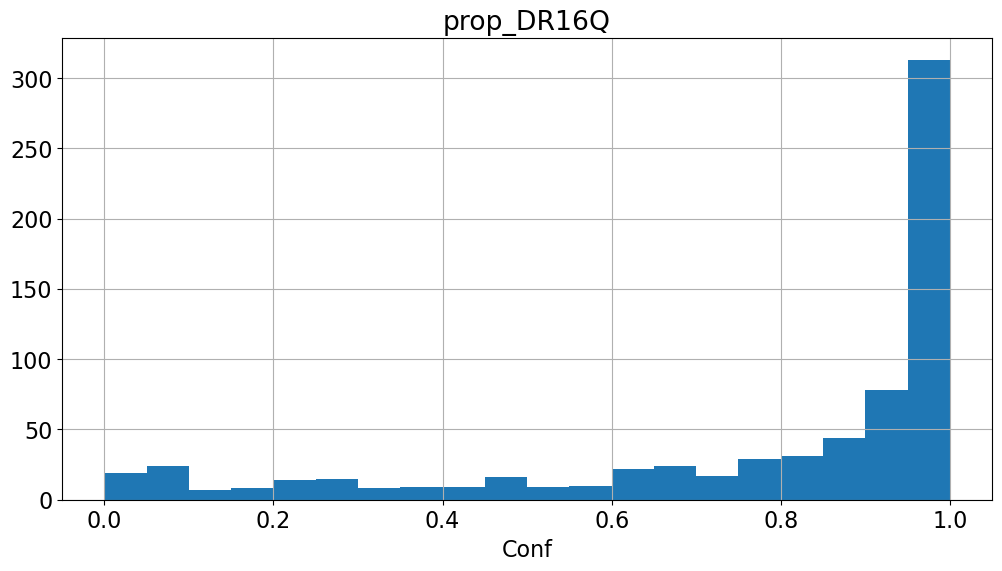

In [107]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()

plt.hist(prop_dens[(prop_dens['target'] == 1) & (prop_dens['Z'] >= 3)]['preds'], bins=20)
plt.xlabel('Conf')
plt.title('prop_DR16Q')

In [108]:
out = dr16q[dr16q['Z'] >= 3][dr16q['preds'] >= 0.5]
out

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs,preds
254370,2.364062,0.771531,3.000000,22.291184,21.894256,21.269562,20.908679,20.950207,21.911347,20.508611,...,0.449028,-0.055325,-0.089876,-0.259471,0.362931,0.252720,DR16Q_22_v4,-2.637069,2.637069,0.890120
254371,39.683192,-0.723210,3.000000,23.738215,22.462789,21.130911,21.091937,20.568998,20.733244,21.043934,...,0.809314,0.110798,0.096502,-0.111080,3.647000,0.206902,DR16Q_22_v4,0.647000,0.647000,0.739659
254381,37.594763,-5.532469,3.001000,22.503220,22.606556,22.433863,22.684165,21.982099,20.716783,22.463981,...,0.388271,-0.350327,0.066075,0.039463,1.268000,0.317339,DR16Q_22_v4,-1.733000,1.733000,0.954209
254398,241.680312,33.209563,3.002938,23.117096,22.400596,21.825150,21.813289,22.126434,21.614661,21.755080,...,-0.284819,-0.415636,-0.394089,-2.668370,2.702000,0.253923,DR16Q_22_v4,-0.300938,0.300938,0.687387
254428,136.522608,14.964513,3.005088,23.306999,21.840451,21.956170,21.982566,21.025809,22.460660,21.903746,...,0.702534,-1.836934,-1.364117,-1.636943,2.351973,0.482067,DR16Q_22_v4,-0.653116,0.653116,0.554910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260365,139.060275,31.044950,7.011245,21.482335,21.251735,20.825714,20.804427,20.632446,21.428634,20.827816,...,0.430450,-0.645543,-0.776375,-1.012587,1.015129,0.237470,DR16Q_22_v4,-5.996116,5.996116,0.994378
260366,341.770887,27.894757,7.011245,21.674032,21.488355,21.111815,20.888735,20.622064,21.690081,20.917052,...,0.045182,-0.163817,-0.017016,-0.332926,1.451578,0.759455,DR16Q_22_v4,-5.559667,5.559667,0.998417
260367,23.595403,16.256553,7.011245,21.688753,21.627957,20.911338,21.081224,20.538696,21.483258,21.040642,...,0.589699,-0.528695,-0.567993,-0.993836,1.161900,0.704290,DR16Q_22_v4,-5.849344,5.849344,0.980888
260368,359.586721,30.006652,7.012407,21.976982,21.611828,21.483509,21.384855,21.397169,21.739690,21.393072,...,0.108862,-0.088343,-0.073072,-0.560012,0.916000,0.264474,DR16Q_22_v4,-6.096407,6.096407,0.998821


In [109]:
s = 0
for i in range(len(quants_test_z)-1):
    s += int(out[(out['Z'] >= quants_test_z[i]) & (out['Z'] <= quants_test_z[i+1])].shape[0] * precs[i])
s

1177

In [110]:
t = pd.read_csv(f'{data_dir}/dr16q_prop_temp.csv')
t.merge(out, on=['RA', 'DEC'], how='inner')

,SDSS_NAME,RA,DEC,Z_DR16Q,Z_SYS,diff,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,...,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs,preds
0,b'005439.36+095236.1',13.664019,9.876710,6.785653,0.115686,6.669967,6.785653,21.862610,21.798693,21.580162,...,0.370259,0.480935,0.409946,0.024410,1.965509,0.478835,DR16Q_22_v4,-4.820144,4.820144,0.975422
1,b'025941.56-052230.6',44.923198,-5.375171,7.002700,0.495294,6.507406,7.002700,21.043031,20.743923,20.224927,...,-0.085912,0.187635,0.058317,-0.898394,1.078498,0.544905,DR16Q_22_v4,-5.924202,5.924202,0.997024
2,b'230519.91+330347.9',346.332993,33.063309,6.923885,0.459663,6.464222,6.923885,23.952718,22.640818,21.071549,...,1.208470,0.252476,0.210238,-0.140751,0.901979,0.288253,DR16Q_22_v4,-6.021906,6.021906,0.987982
3,b'021756.27-052603.2',34.484475,-5.434227,7.007659,0.632710,6.374949,7.007659,21.994566,21.664698,21.440275,...,0.658634,-0.333813,-0.236421,-0.403244,0.627000,0.594725,DR16Q_22_v4,-6.380659,6.380659,0.979624
4,b'231539.92+035904.0',348.916335,3.984459,6.944552,0.684310,6.260242,6.944552,21.935907,21.514601,21.098352,...,0.556576,0.170358,0.148249,-0.606713,0.640000,0.552452,DR16Q_22_v4,-6.304552,6.304552,0.929348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,b'085518.23+373218.7',133.825958,37.538553,3.427880,2.503246,0.924634,3.427880,20.933899,20.597273,20.461928,...,0.510904,-1.594511,-1.656603,-1.608885,0.876477,0.486777,DR16Q_22_v4,-2.551403,2.551403,0.652507
524,b'211532.98-000122.2',318.887424,-0.022857,3.439555,2.515576,0.923979,3.439555,21.997608,22.022614,21.886635,...,0.326814,0.044335,-0.046375,-0.380145,1.208933,0.238166,DR16Q_22_v4,-2.230622,2.230622,0.650622
525,b'212322.74-004447.7',320.844752,-0.746609,3.176000,2.298040,0.877960,3.176000,24.271228,22.452988,22.343238,...,0.826418,-0.637704,-0.919799,-0.034857,2.325000,0.408993,DR16Q_22_v4,-0.851000,0.851000,0.902758
526,b'012232.26+130951.4',20.634432,13.164282,3.031744,2.162555,0.869190,3.031744,21.684739,21.513019,21.399371,...,0.342089,-0.030242,0.100569,-0.457557,0.829000,0.528620,DR16Q_22_v4,-2.202744,2.202744,0.669494


In [111]:
t = Table.read(f'{data_dir}/dr16q_prop_Sep08_2022.fits')
print(t.colnames)
dr16q_prop_full = t[['OBJID', 'RA', 'DEC', 'Z_DR16Q', 'Z_SYS']].to_pandas()

['SDSS_NAME', 'PLATE', 'MJD', 'FIBERID', 'RA', 'DEC', 'OBJID', 'IF_BOSS_SDSS', 'Z_DR16Q', 'SOURCE_Z_DR16Q', 'Z_FIT', 'Z_SYS', 'Z_SYS_ERR', 'EBV', 'SN_MEDIAN_ALL', 'CONTI_FIT', 'CONTI_FIT_ERR', 'CONTI_STAT', 'FEII_UV', 'FEII_UV_ERR', 'FEII_UV_EW', 'FEII_UV_EW_ERR', 'FEII_OPT', 'FEII_OPT_ERR', 'FEII_OPT_EW', 'FEII_OPT_EW_ERR', 'LOGL1350', 'LOGL1350_ERR', 'LOGL1700', 'LOGL1700_ERR', 'LOGL3000', 'LOGL3000_ERR', 'LOGL5100', 'LOGL5100_ERR', 'HALPHA', 'HALPHA_BR', 'NII6585', 'SII6718', 'HBETA', 'HBETA_BR', 'HEII4687', 'HEII4687_BR', 'OIII5007', 'OIII5007C', 'CAII3934', 'OII3728', 'NEV3426', 'MGII', 'MGII_BR', 'CIII_ALL', 'CIII_BR', 'SIIII1892', 'ALIII1857', 'NIII1750', 'CIV', 'HEII1640', 'HEII1640_BR', 'SIIV_OIV', 'OI1304', 'LYA', 'NV1240', 'HALPHA_ERR', 'HALPHA_BR_ERR', 'NII6585_ERR', 'SII6718_ERR', 'HBETA_ERR', 'HBETA_BR_ERR', 'HEII4687_ERR', 'HEII4687_BR_ERR', 'OIII5007_ERR', 'OIII5007C_ERR', 'CAII3934_ERR', 'OII3728_ERR', 'NEV3426_ERR', 'MGII_ERR', 'MGII_BR_ERR', 'CIII_ALL_ERR', 'CIII_BR_

In [112]:
dr16q_prop_full = dr16q_prop_full[dr16q_prop_full['Z_DR16Q'] >= 3]
dr16q_prop_full.sort_values(by=['Z_DR16Q'], inplace=True, ascending=True)
dr16q_prop_full.reset_index(drop=True, inplace=True)
dr16q_prop_full['Z'] = dr16q_prop_full['Z_DR16Q']
dr16q_prop_full

,OBJID,RA,DEC,Z_DR16Q,Z_SYS,Z
0,b'3784-55269-0008',154.958582,-2.934004,3.000000,2.990805,3.000000
1,b'6466-56310-0846',152.921952,25.684206,3.000000,2.995503,3.000000
2,b'7123-56726-0309',212.041159,63.512841,3.000000,3.010367,3.000000
3,b'6602-56571-0632',23.367924,34.397596,3.000000,2.994826,3.000000
4,b'6407-56311-0769',179.297445,20.837343,3.000000,2.994511,3.000000
...,...,...,...,...,...,...
39656,b'7656-57338-0588',341.770887,27.894757,7.011245,1.327632,7.011245
39657,b'7696-57655-0810',359.586721,30.006652,7.012407,1.040394,7.012407
39658,b'11089-58467-0917',134.966785,19.867148,7.014935,0.997404,7.014935
39659,b'8292-57373-0007',123.520783,41.513521,7.014980,1.289744,7.014980


In [113]:
res = out[['RA', 'DEC', 'Z', 'zoo_x1a35_z_max', 'zoo_x1a35_z_maxConf']].merge(dr16q_prop_full, on=['RA', 'DEC', 'Z'], how='inner')

In [114]:
res = res.drop(columns=['Z'])

In [115]:
res.to_csv(f'{data_dir}/dr16q_outliers.csv', index=False)

In [116]:
res['Z_SYS'].min()

-999.0

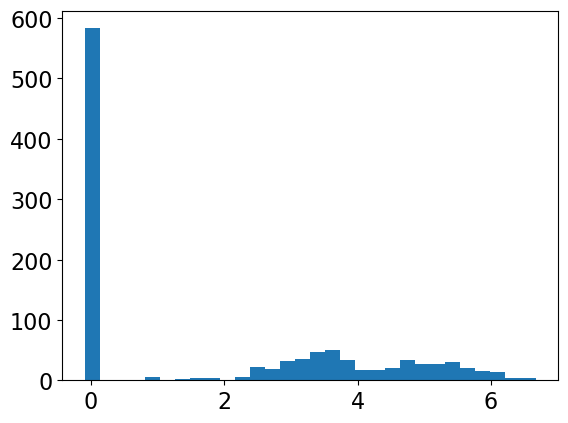

In [117]:
plt.hist(res[res['Z_SYS'] >= 0.0]['Z_DR16Q'] - res[res['Z_SYS'] >= 0.0]['Z_SYS'], bins=30);

In [118]:
t = Table.read(f'{data_dir}/23_DR16Q_v4.fits')
# print(t.colnames)
# dr16q_full = t[['THING_ID', 'SDSS_NAME', 'RA', 'DEC', 'Z', 'CLASS_PERSON', 'AUTOCLASS_PQN', 'AUTOCLASS_DR14Q']].to_pandas()

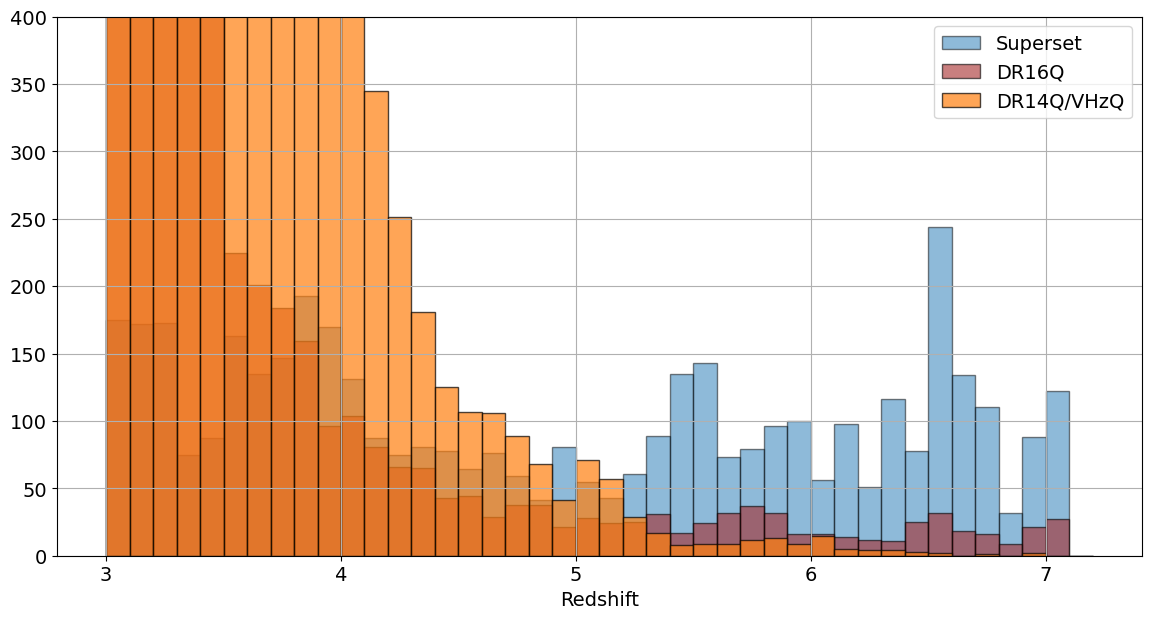

In [119]:
font = {'size': 14}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 7))
plt.ylim(0, 400)
# plt.xlim(3, 7.1)
plt.grid()

log=False

# plt.hist(dr16q_full[dr16q_full['Z'] > -0.1]['Z'], bins=100, alpha=0.7, label='dr16q_full', log=log, color='r');
# values, bins, _ = plt.hist(dr16q['Z'], bins=100, alpha=0.7, label='dr16q', log=log);
# plt.hist(dr16q[dr16q['preds'] >= 0.5]['Z'], bins=100, alpha=0.7, label='outliers', log=log)
# plt.hist(prop_dr16q['Z'], bins=100, alpha=0.7, label='prop_dr16q', log=log);
# plt.plot((bins[1:] + bins[:-1]) / 2, 0.05 * values, c='white', label='5% dr16q')

plt.hist(superset[superset['Z'] > -0.1]['Z'], bins=np.arange(3.0,7.3,0.1), alpha=0.5, label='Superset', log=log, edgecolor="black")
plt.hist(dr16q[dr16q['Z'] > -0.1]['Z'], bins=np.arange(3.0,7.3,0.1), alpha=0.6, label='DR16Q', log=log, color='brown', edgecolor="black")
plt.hist(train_20[train_20['Z'] > -0.1]['Z'], bins=np.arange(3.0,7.3,0.1), alpha=0.7, label='DR14Q/VHzQ', log=log, edgecolor="black")


plt.xlabel('Redshift')
# plt.ylabel()
plt.legend();

In [120]:
prop_dr16q.shape[0]

1362

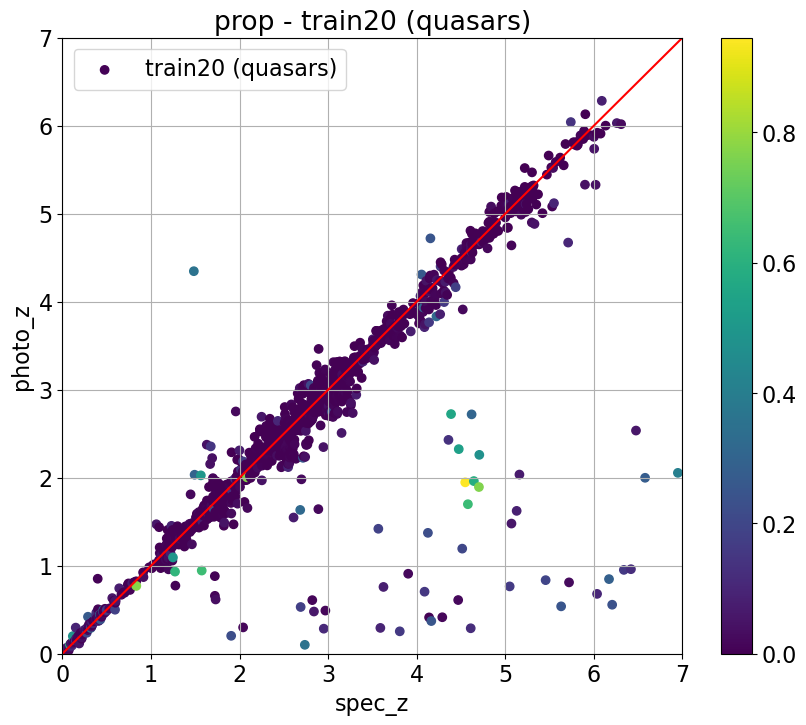

In [121]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 8))
plt.ylim(0, 7)
plt.xlim(0, 7)
plt.grid()

t = prop[prop['target'] == 0]
plt.scatter(t['Z'], t['zoo_x1a35_z_max'], c=t['preds'], label='train20 (quasars)');
plt.plot(range(0,8), range(0,8), c='r')
plt.colorbar()
plt.legend()
plt.xlabel('spec_z')
plt.ylabel('photo_z')
plt.title('prop - train20 (quasars)');

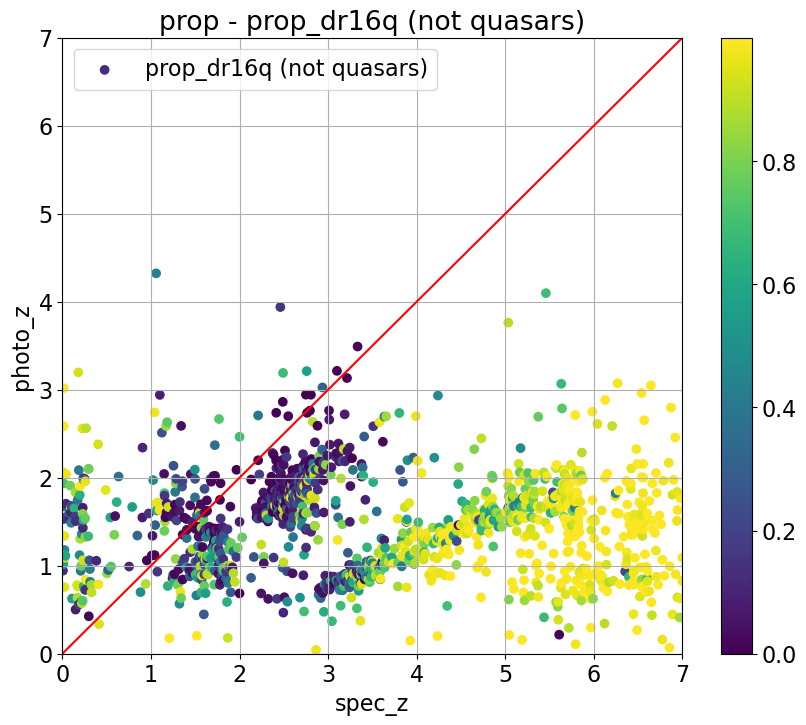

In [122]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 8))
plt.ylim(0, 7)
plt.xlim(0, 7)
plt.grid()

t = prop[prop['target'] == 1]
plt.scatter(t['Z'], t['zoo_x1a35_z_max'], c=t['preds'], label='prop_dr16q (not quasars)');
plt.plot(range(0,8), range(0,8), c='r')
plt.colorbar()
plt.legend()
plt.xlabel('spec_z')
plt.ylabel('photo_z')
plt.title('prop - prop_dr16q (not quasars)');

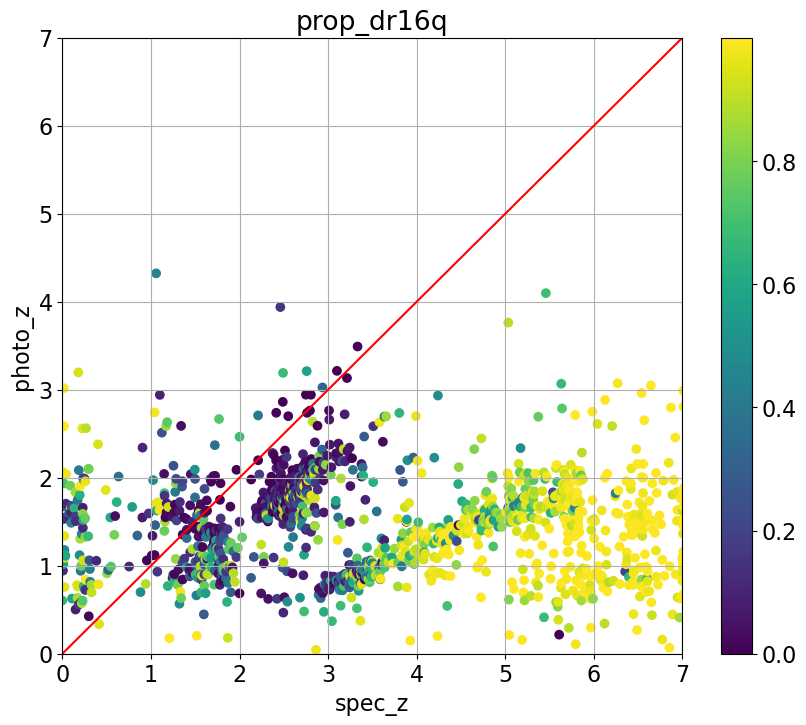

In [123]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 8))
plt.ylim(0, 7)
plt.xlim(0, 7)
plt.grid()

plt.scatter(prop_dr16q['Z'], prop_dr16q['zoo_x1a35_z_max'], c=prop_dr16q_preds);
plt.plot(range(0,8), range(0,8), c='r')
plt.colorbar()
plt.xlabel('spec_z')
plt.ylabel('photo_z')
plt.title('prop_dr16q');

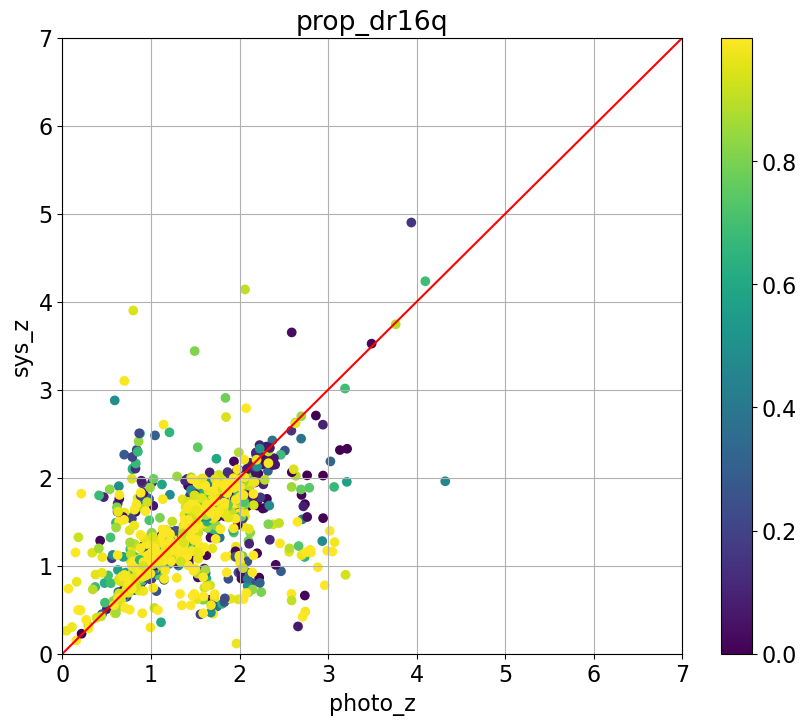

In [124]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 8))
plt.ylim(0, 7)
plt.xlim(0, 7)
plt.grid()

plt.scatter(prop_dr16q['zoo_x1a35_z_max'], prop_dr16q['Z_SYS'], c=prop_dr16q_preds);
plt.plot(range(0,8), range(0,8), c='r')
plt.colorbar()
plt.xlabel('photo_z')
plt.ylabel('sys_z');
plt.title('prop_dr16q');

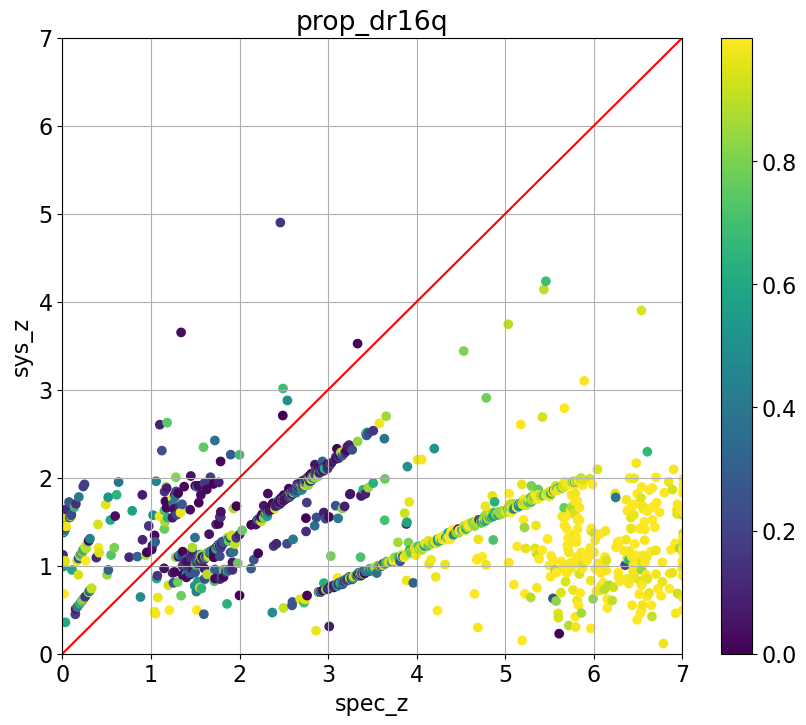

In [125]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 8))
plt.ylim(0, 7)
plt.xlim(0, 7)
plt.grid()

plt.scatter(prop_dr16q['Z'], prop_dr16q['Z_SYS'], c=prop_dr16q_preds);
plt.plot(range(0,8), range(0,8), c='r')
plt.colorbar()
plt.xlabel('spec_z')
plt.ylabel('sys_z');
plt.title('prop_dr16q');

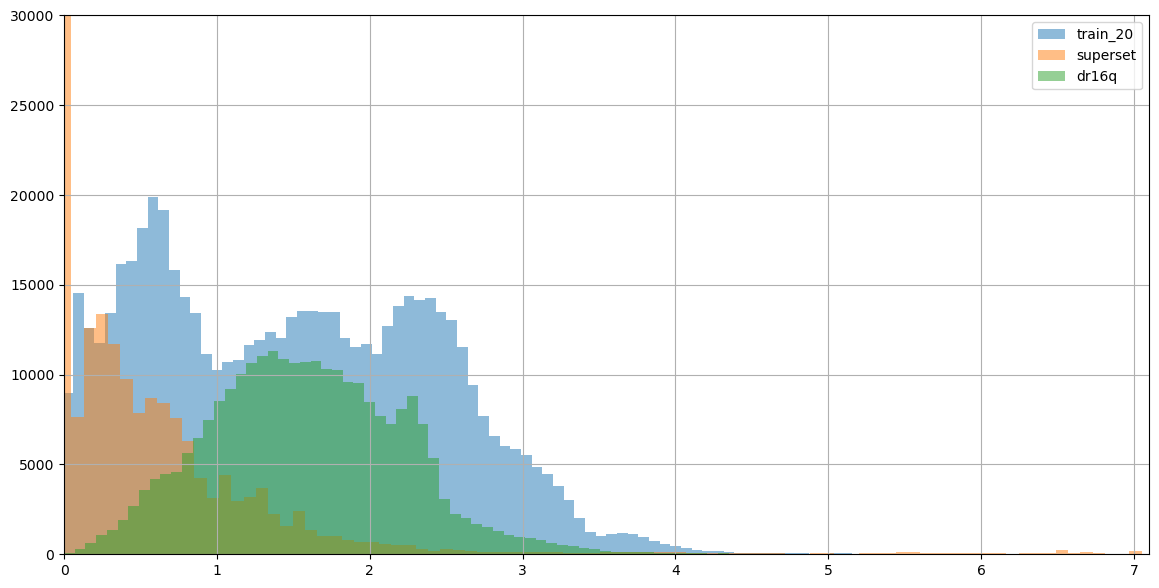

In [126]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 7))
plt.ylim(0, 30000)
plt.xlim(0, 7.1)
plt.grid()

plt.hist(train_20['Z'], bins=100, alpha=0.5, label='train_20');
plt.hist(superset['Z'], bins=100, alpha=0.5, label='superset');
plt.hist(dr16q['Z'], bins=100, alpha=0.5, label='dr16q');
plt.legend();

In [127]:
kd_tree = KDTree(prop_dr16q[['RA', 'DEC']].values)
d, idx = kd_tree.query(dr16q[['RA', 'DEC']].values)
m = (d >= 0.0000001)
# m.sum()

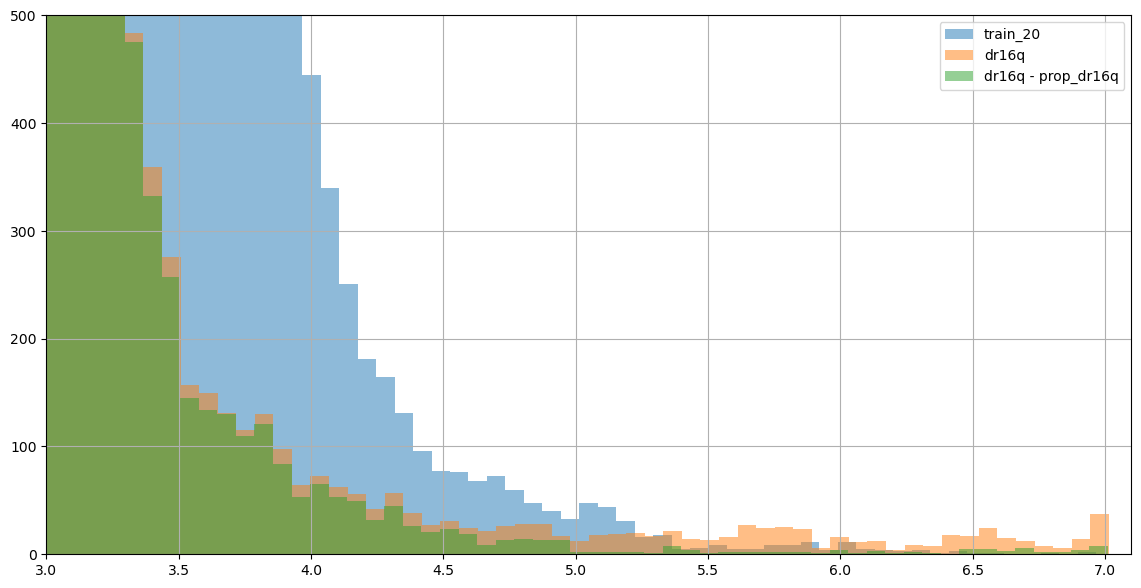

In [128]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 7))
plt.xlim(3, 7.1)
plt.ylim(0, 500)
plt.grid()

plt.hist(train_20['Z'], bins=100, alpha=0.5, label='train_20');
plt.hist(dr16q['Z'], bins=100, alpha=0.5, label='dr16q');
# plt.hist(prop_dr16q['Z'], bins=100, alpha=0.5, label='prop_dr16q');
plt.hist(dr16q[m]['Z'], bins=100, alpha=0.5, label='dr16q - prop_dr16q');
plt.legend();

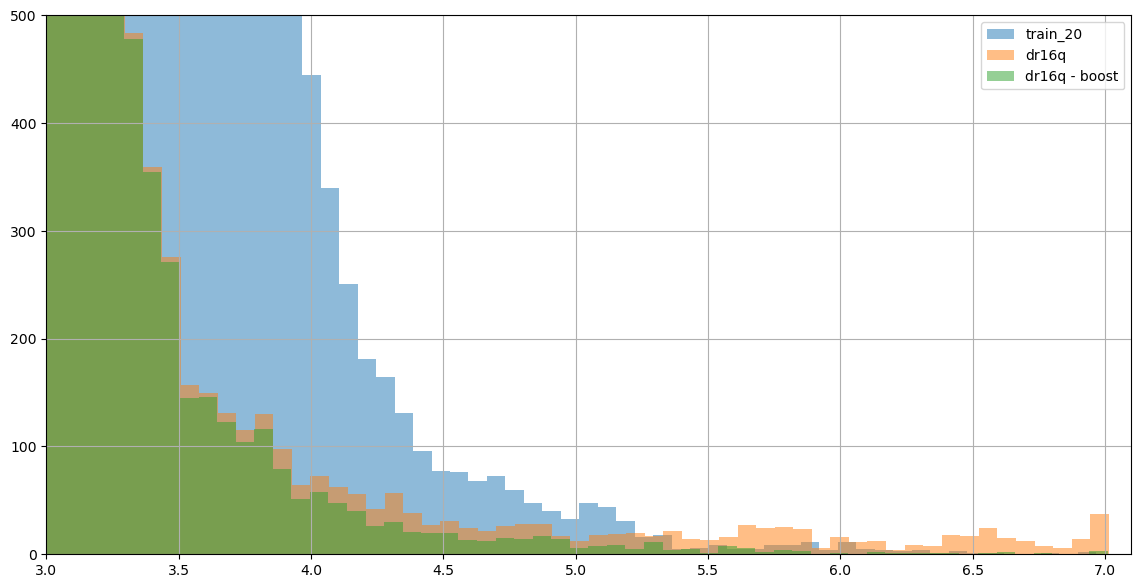

In [129]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 7))
plt.xlim(3, 7.1)
plt.ylim(0, 500)
plt.grid()

plt.hist(train_20['Z'], bins=100, alpha=0.5, label='train_20');
plt.hist(dr16q['Z'], bins=100, alpha=0.5, label='dr16q');
plt.hist(dr16q[dr16q_preds <= 0.9]['Z'], bins=100, alpha=0.5, label='dr16q - boost')
plt.legend();